##  Importation des librairies

In [1]:
import nltk
#from nltk.stem.lancaster import LancasterStemmer
#stemmer = LancasterStemmer()
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()
import warnings

In [2]:
from nltk.corpus import wordnet
from collections import OrderedDict
from deep_translator import GoogleTranslator
import numpy as np

from sklearn.linear_model import LogisticRegression
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import json
import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords

from nltk.stem.snowball import FrenchStemmer
import string
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV

from sklearn import svm
from sklearn.svm import SVC
import joblib

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay

# Récupération du corpus 

In [3]:
# import our chat-bot intents file


def import_corpus(jsonfile): #permet d'importer le corpus
    try:
        with open(jsonfile, encoding='utf-8') as json_data:
            intents = json.load(json_data)
        return intents

    except OSError as err:
        print("OS error: {0}".format(err))
    except ValueError:
        print("Your .json is wrong, look at https://jsonlint.com/")
    except BaseException as err:
        print(f"Unexpected {err=}, {type(err)=}")
        raise
        
corpus = import_corpus('intents.json')
#corpus

# Extraction_data_X_Y
- Séparation et récupération des tags, Patterns et Responses
- Séparer les données en test et train 
- Création d'un dictionnaire associant un tag à une réponse 
- Nettoyage des ponctuations

In [4]:


def extraction_data_X_y(jsonfile = None, testing = False, phrase : str = None, context : str = "ISEN"): #permet d'obtenir les patterns (X_text) et les tags (y_text)
    
    ponctuation = [".", "?", "!", ",", ";", ":", "(",  ")", "[", "]", "«", "»", '"', "/", "}", "{", "'", "#","-","’"]

    if testing == False : #cas d'extraction des données du corpus
        corpus = import_corpus(jsonfile)
    
        X_texte = []
        y_texte = []
        Responses = []

        dico_tag_responses = {}

        #ponctuation = [".", "?", "!", ",", ";", ":", "(",  ")", "[", "]", "«", "»", '"', "/", "}", "{", "'", "#","-","’"]
        try :
            for doc in corpus['intents']: #'intents
                #print(doc['tag']) #obtenir chaque tag
                for p in doc['patterns']: #'patterns'
                    #print(p) #obtenir chaque phrase/patterns par tags 
                    #if isen == "ISEN" & doc["context"] == "ISEN": #cas où on souhaite faire un modèle sur les context = ["ISEN"]
                        
                    #print(f'doc["context"] : {doc["context"]}')
                    if context == "ISEN" and doc["context"] == ['ISEN']:
                        #print(f'doc["context"] : {doc["context"]}')
          
                    
            
                        for element in ponctuation:
                            p = p.replace(element," ")
                            #filtered_phrase = clean_text(p)
                        filtered_phrase = p

                            #X_texte.append(" ".join(filtered_phrase)) Bonne version avec stemming
                        X_texte.append(filtered_phrase)

                        y_texte.append(doc['tag']) 
                            #y_texte.append(doc['tag']) #on rajoute un 2e même tag car on double le dataset

                        Responses.append(doc['responses'])
                        dico_tag_responses[doc['tag']] = doc['responses']
                                          

                    
                            
                    elif context == "IA-MICROSOFT" and doc["context"] == ["IA-MICROSOFT"]:
                        #print(f'doc["context"] : {doc["context"]}')
                        
                        for element in ponctuation:
                            p = p.replace(element," ")
                        #filtered_phrase = clean_text(p)
                        filtered_phrase = p

                        #X_texte.append(" ".join(filtered_phrase)) Bonne version avec stemming
                        X_texte.append(filtered_phrase)

                        y_texte.append(doc['tag']) 
                        #y_texte.append(doc['tag']) #on rajoute un 2e même tag car on double le dataset

                        Responses.append(doc['responses'])
                        dico_tag_responses[doc['tag']] = doc['responses']
                        

            X_train, X_test, y_train, y_test = train_test_split(X_texte,y_texte,train_size=0.8)

            #print(f"\ndico_tag_responses : \n {dico_tag_responses}")
            return X_texte, y_texte, X_train, X_test, y_train, y_test, dico_tag_responses
        except:
            print("l'extraction des patterns et tags n'a pas fonctionnée, allez voir la fonction extraction data_X_y")
            
    else: #cas en utilisation pour récupérer la phrase
        #new_phrase = []
        
        for element in ponctuation:
            phrase = phrase.replace(element," ")
        
        new_phrase = phrase
        return new_phrase
        
X_text = []
y_text = []
X_texte_ISEN, y_texte_ISEN, X_train_ISEN, X_test_ISEN, y_train_ISEN, y_test_ISEN, dico_tag_responses_ISEN = extraction_data_X_y('intents.json')
X_texte_IA_MICROSOFT, y_texte_IA_MICROSOFT, X_train_IA_MICROSOFT, X_test_IA_MICROSOFT, y_train_IA_MICROSOFT, y_test_IA_MICROSOFT, dico_tag_responses_IA_MICROSOFT = extraction_data_X_y('intents.json', context = "IA-MICROSOFT")
#dico_tag_responses
#phrase_test = "Puis-je visiter l'isen?"
#extraction_data_X_y(None, True, phrase_test)


In [5]:
extraction_data_X_y(testing = True,
                    phrase = "Ceci est une phrase pour tester la disparition des ponctuations, comme la suppression de l’apostrophe.")

'Ceci est une phrase pour tester la disparition des ponctuations  comme la suppression de l apostrophe '

# data_augmentation_syn
- Data augmentation sur les patterns 

In [9]:
def find_synonyms(word):
    translated_word = GoogleTranslator(source='fr', target='en').translate(word)
    synonyms = []
    for synset in wordnet.synsets(translated_word):
        for syn in synset.lemma_names():
            synonyms.append(GoogleTranslator(source='en', target='fr').translate(syn))
            #print(syn,"sa traduction en français",GoogleTranslator(source='en', target='fr').translate(syn))
            
    # using this to drop duplicates while maintaining word order (closest synonyms comes first)
    synonyms_without_duplicates = list(OrderedDict.fromkeys(synonyms))
    return list(OrderedDict.fromkeys(synonyms)) #synonyms #synonyms_without_duplicates

find_synonyms("eau")

["l'eau",
 'H2O',
 "plan d'eau",
 "système d'eau",
 'approvisionnement en eau',
 'urine',
 'pisse',
 'pipi',
 'faire pipi',
 'irriguer']

In [7]:

def create_set_of_new_sentences(sentence, max_syn_per_word = 6, nbr_new_sentences = 1): #nbr_new_sentences est le nombre de "nouvelle" phrase crée par phrase, si =1 on va doubler le dataset par exemple
    try:
        new_sentences = []
        for word in nltk.word_tokenize(sentence):
            #print("\n")
            if len(word)<=3 : continue #les petits mots ont souvent des erreurs en synonymes
            for synonym in find_synonyms(word)[0:max_syn_per_word]:
                
                #print(synonym, word)
                synonym = synonym.replace('_', ' ') #restore space character
                new_sentence = sentence.replace(word,synonym)
                new_sentences.append(new_sentence)
        return new_sentences[1:nbr_new_sentences+1] #le premier correspond à la phrase initiale
    except:
        print("Peut être que votre phrase n'est pas dans la bonne langue (Français) ou que vous n'avez rien mis en entrée de la fonction")

create_set_of_new_sentences("C est quoi le cursus de l école", nbr_new_sentences = 2)

['C est quoi le programme de l école',
 "C est quoi le programme d'études de l école"]

In [37]:
#import time
def data_augmentation_syn(X_train,y_train, nbr_new_sentences = 1): #need X_train et y_train au format texte
    
    #start = time.time()
    
    print(f"\nX_train {X_train} de taille {len(X_train)}")
    print(f"\ny_train {y_train} de taille {len(y_train)}")
    
    
    X_train_complete=[] #pour stocker les phrases complètes
    
    X_train_augmented = [] #[[0] for i in range(len(X_train)*(1+nbr_new_sentences))] #pour créer une liste de bonne taille
    y_train_augmented= [] #X_train_augmented #y_train_augmented sera de même taille que X_train_augmented
        
    #Pour avoir les phrases complètes (et pas des listes de mots pour une phrase) (ex: on veut [phrase1,phrase2,phrase3] et X_train est au départ sous format [[mot1_phrase1,mot2_phase1],[mot1_phrase2...
    for phrase in X_train :
        X_train_complete.append(phrase) 
    #print(f"X_train_complete {X_train_complete} et taille : {len(X_train_complete)}")
    
    
    i=0
    for phrase_initiale in X_train:
        print(f"\nphrase initiale : {phrase_initiale}")
        X_train_augmented.append(phrase_initiale)
        y_train_augmented.append(y_train[i])
        new_phrases=create_set_of_new_sentences(phrase_initiale, None, nbr_new_sentences)
        print(new_phrases)
        
        try :
            for new_phrase in new_phrases:
                print(f"NOUVELLE phrase : {new_phrase}")
                X_train_augmented.append(new_phrase)
                y_train_augmented.append(y_train[i])
            #i+=1
        except : 
            print(f"{phrase_initiale} n'a pas pu avoir de phrases synonymes")
        i+=1
        
    #end = time.time()
    #print(end - start)
    
    print(f"\nX_train_augmented {X_train_augmented} de taille {len(X_train_augmented)}")
    print(f"\ny_train_augmented {y_train_augmented} de taille {len(y_train_augmented)}")
    return (X_train_augmented, y_train_augmented)

"""
X_train_augmented_ISEN, y_train_augmented_ISEN = data_augmentation_syn(X_texte_ISEN, y_texte_ISEN, nbr_new_sentences=2)
X_train_augmented_IA_MICROSOFT, y_train_augmented_IA_MICROSOFT = data_augmentation_syn(X_texte_IA_MICROSOFT, y_texte_IA_MICROSOFT, nbr_new_sentences=2)
"""


X_train ['Salut', 'Salut à tous', 'Bonjour à tous', 'Bonjour', 'Coucou', 'Comment ca va ', 'Comment tu vas ', 'je recherche de l aide', 'oyez oyez', 'hey', 'Pourquoi l isen  ', 'description isen', 'école d ingénieur généraliste', 'C est quoi la différence avec les autres écoles d ingénieurs  ', 'Quelle est la différence avec les autres écoles d ingénieurs  ', 'différence autres écoles ingénieurs', 'en quoi l isen est meilleur ', 'Pourquoi choisir l isen ', 'quelles sont les avantages offert par l isen ', 'qu offre l isen en termes d enseignement ', 'quelles performances peut on retrouvés à l isen', 'C est quoi l ISEN  ', 'cursus isen', 'années scolarité', 'En combien d années se déroule l ISEN  ', 'Qu est ce que l ISEN', 'C est quoi le cursus de l école', 'Combien d années d études post bac ', 'temps post bac', 'peut on intégrer l école après le bac', 'comment foncionne l ISEN', 'comment est on formé à l isen ', 'quelles sont les différentes possibilités suivant mon profil ', 'quels s

## sauvegarde des variables
- Les variables ci-dessus peuvent être stocker manuellement ou dans un fichier dans cette partie

In [8]:
#new
X_train_augmented_ISEN = ['Salut', 'salut', 'Salut à tous', 'salut à tous', 'Salut à tous', 'Bonjour à tous', 'Tiens à tous', 'salut à tous', 'Bonjour', 'Tiens', 'salut', 'Coucou', 'Tiens', 'salut', 'Comment ca va ', 'Comment tu vas ', 'je recherche de l aide', 'je enquête de l aide', 'je chercher de l aide', 'oyez oyez', 'apprendre apprendre', 'get word get word', 'hey', 'Pourquoi l isen  ', 'pour cette raison l isen  ', 'description isen', 'description verbale isen', 'école d ingénieur généraliste', 'école d ingénieur généraliste', 'scolarité d ingénieur généraliste', 'C est quoi la différence avec les autres écoles d ingénieurs  ', 'C est quoi la déviation avec les autres écoles d ingénieurs  ', 'C est quoi la divergence avec les autres écoles d ingénieurs  ', 'Quelle est la différence avec les autres écoles d ingénieurs  ', 'Quelle est la déviation avec les autres écoles d ingénieurs  ', 'Quelle est la divergence avec les autres écoles d ingénieurs  ', 'différence autres écoles ingénieurs', 'déviation autres écoles ingénieurs', 'divergence autres écoles ingénieurs', 'en quoi l isen est meilleur ', 'en quoi l isen est parieur ', 'en quoi l isen est Pause ', 'Pourquoi choisir l isen ', 'pour cette raison choisir l isen ', 'Pourquoi choisir l isen ', 'quelles sont les avantages offert par l isen ', 'quelles ar les avantages offert par l isen ', 'quelles être les avantages offert par l isen ', 'qu offre l isen en termes d enseignement ', 'qu offre l isen en termes d enseignement ', 'qu fissure l isen en termes d enseignement ', 'quelles performances peut on retrouvés à l isen', 'quelles présentation publique peut on retrouvés à l isen', 'quelles exécution peut on retrouvés à l isen', 'C est quoi l ISEN  ', 'cursus isen', 'programme isen', "programme d'études isen", 'années scolarité', 'années scolarité', 'âge scolarité', 'En combien d années se déroule l ISEN  ', 'En combien d années se déroule l ISEN  ', 'En combien d âge se déroule l ISEN  ', 'Qu est ce que l ISEN', 'C est quoi le cursus de l école', 'C est quoi le programme de l école', "C est quoi le programme d'études de l école", 'Combien d années d études post bac ', 'Combien d années d études post bac ', 'Combien d âge d études post bac ', 'temps post bac', 'agrafe post bac', "temps d'horloge post bac", 'peut on intégrer l école après le bac', 'étain on intégrer l école après le bac', 'boîte de conserve on intégrer l école après le bac', 'comment foncionne l ISEN', 'comment œuvres l ISEN', 'comment installation industrielle l ISEN', 'comment est on formé à l isen ', 'comment est on forme lexicale à l isen ', 'comment est on signifiant à l isen ', 'quelles sont les différentes possibilités suivant mon profil ', 'quelles ar les différentes possibilités suivant mon profil ', 'quelles être les différentes possibilités suivant mon profil ', 'quels sont les enseignements à l isen ', 'quels ar les enseignements à l isen ', 'quels être les enseignements à l isen ', '204 écoles d ingénieurs', '204 école d ingénieurs', '204 scolarité d ingénieurs', 'ingénieur français', 'scientifique appliqué français', 'technologue français', 'C est quoi Yncréa Ouest  ', 'Combien y a t il d écoles dans l ouest ', 'Combien y a t il d école dans l ouest ', 'Combien y a t il d scolarité dans l ouest ', 'Quels sont les campus de l ISEN Ouest  ', 'Quels ar les campus de l ISEN Ouest  ', 'Quels être les campus de l ISEN Ouest  ', 'Brest  Caen  Nantes et Rennes', 'Brest  Caen  Nantes et Rennes', 'Brest  Caen  Nantes et caribou', 'Où peut on étudier à l ISEN ', 'Où étain on étudier à l ISEN ', 'Où boîte de conserve on étudier à l ISEN ', 'quelles sont les centre de formation de l isen ', 'quelles ar les centre de formation de l isen ', 'quelles être les centre de formation de l isen ', 'quelle est la localisation de l ISEN ', 'quelle est la placement de l ISEN ', 'quelle est la localiser de l ISEN ', 'Quelles sont les certifications d Yncréa  ', 'Quelles ar les certifications d Yncréa  ', 'Quelles être les certifications d Yncréa  ', 'L isen est il sous contrat avec le Ministère de l Enseignement Supérieur et de la Recherche  ', 'L isen est il en dessous de contrat avec le Ministère de l Enseignement Supérieur et de la Recherche  ', 'L isen est il au dessous de contrat avec le Ministère de l Enseignement Supérieur et de la Recherche  ', 'L isen est il sous contrat avec le MESR  ', 'L isen est il en dessous de contrat avec le MESR  ', 'L isen est il au dessous de contrat avec le MESR  ', 'gage de qualité de l isen', 'griller de qualité de l isen', 'assurance de qualité de l isen', 'MESR', 'L isen est il reconnu de quelconques manières ', 'L isen est il reconnaître de quelconques manières ', 'L isen est il connaître de quelconques manières ', 'Qu offre l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Qu offre l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Qu fissure l ISEN en terme d assurrance de reconnaissance du niveau de sortie ', 'Quel est le taux d insertion des jeunes diplômés  ', 'Quel est le charge per unit d insertion des jeunes diplômés  ', 'Quel est le rythme d insertion des jeunes diplômés  ', 'taux d insertion', 'charge per unit d insertion', 'rythme d insertion', 'Où sont embauchés les jeunes diplômés  ', 'Où ar embauchés les jeunes diplômés  ', 'Où être embauchés les jeunes diplômés  ', 'lieu d embauche', 'placement d embauche', 'localiser d embauche', 'Quels sont les lieux de travail après diplôme  ', 'Quels ar les lieux de travail après diplôme  ', 'Quels être les lieux de travail après diplôme  ', 'Trouve t on facilement du diplôme après l isen ', 'percée t on facilement du diplôme après l isen ', 'trouver t on facilement du diplôme après l isen ', 'Est on obligé de travailler sur paris après notre diplome ', 'Est on obligé de travailler sur Paris après notre diplome ', 'Est on obligé de travailler sur Ville de lumière après notre diplome ', 'Quelle est le taux d embauches après l ISEN ', 'Quelle est le charge per unit d embauches après l ISEN ', 'Quelle est le rythme d embauches après l ISEN ', 'C est quoi Yncrea  ', 'Qu est ce que Yncréa  ', 'Yncrea', 'Junia', 'Yncrea ouest', 'Yncrea medittérannée', 'Yncrea Mer Méditerranée', 'Yncrea Nord', 'Yncrea syndicat', 'Yncrea due north', 'L isen fait elle est partie d un groupe ', 'L isen fais elle est partie d un groupe ', 'L isen avoir elle est partie d un groupe ', 'Pourquoi Yncrea ', 'pour cette raison Yncrea ', 'Quelle différences entre l isen et l Yncrea ', 'Quelle déviation entre l isen et l Yncrea ', 'Quelle divergence entre l isen et l Yncrea ', 'Combien y a t il d étudiants  ', 'Combien y a t il d instruit  ', 'Combien y a t il d savant  ', 'Combien y a t il d enseignants permanents ', 'Combien y a t il d instructeur permanents ', 'Combien y a t il d enseignants vague permanente ', 'Combien y a t il d alumnis  ', 'Combien y a t il d ancienne élève  ', 'Combien y a t il d alun  ', 'nombre étudiants', 'chiffre étudiants', 'acte étudiants', 'nombre élèves', 'chiffre élèves', 'acte élèves', 'Quelles est le chiffre d étudiants à l isen ', 'Quelles est le figure d étudiants à l isen ', 'Quelles est le corps humain d étudiants à l isen ', 'Quelle est la population de l isen ', 'Quelle est la univers de l isen ', 'Quels sont les tarifs du cycle CGSI  ', 'Quels ar les tarifs du cycle CGSI  ', 'Quels être les tarifs du cycle CGSI  ', 'prix CGSI', 'le prix CGSI', 'Coût CGSI', 'Quels sont les frais de scolarité du cycle CGSI  ', 'Quels ar les frais de scolarité du cycle CGSI  ', 'Quels être les frais de scolarité du cycle CGSI  ', 'Combien coûte les années 1 et 2 en CSI  ', 'Combien valeur monétaire les années 1 et 2 en CSI  ', 'Combien le prix les années 1 et 2 en CSI  ', 'Combien coûte les années 1 et 2 classes préparatoires implantées', 'Combien valeur monétaire les années 1 et 2 classes préparatoires implantées', 'Combien le prix les années 1 et 2 classes préparatoires implantées', 'tarif CGSI', 'charge per unit CGSI', 'rythme CGSI', 'tarif CSI', 'charge per unit CSI', 'rythme CSI', 'Quelle est le montant d une année du cycle généraliste ', "Quelle est le somme d'argent d une année du cycle généraliste ", 'Quelle est le montant d une année du cycle généraliste ', 'une année du cycle généraliste  ça coute combien ', 'une classer du cycle généraliste  ça coute combien ', 'une année du cycle généraliste  ça coute combien ', 'Quels sont les tarifs du cycle CIR ', 'Quels ar les tarifs du cycle CIR ', 'Quels être les tarifs du cycle CIR ', 'tarif CIR', 'charge per unit CIR', 'rythme CIR', 'prix CIR', 'le prix CIR', 'Coût CIR', 'Quels sont les frais de scolarité du cycle CIR ', 'Quels ar les frais de scolarité du cycle CIR ', 'Quels être les frais de scolarité du cycle CIR ', 'Combien coûte les années 1 et 2 en CIR ', 'Combien valeur monétaire les années 1 et 2 en CIR ', 'Combien le prix les années 1 et 2 en CIR ', 'Combien coûte les années 1 et 2 en Cycle Informatique et Réseaux', 'Combien valeur monétaire les années 1 et 2 en Cycle Informatique et Réseaux', 'Combien le prix les années 1 et 2 en Cycle Informatique et Réseaux', 'Quelle est le montant d une année du cycle informatique ', "Quelle est le somme d'argent d une année du cycle informatique ", 'Quelle est le montant d une année du cycle informatique ', 'une année du cycle informatique  ça coute combien ', 'une classer du cycle informatique  ça coute combien ', 'une année du cycle informatique  ça coute combien ', 'Quels sont les tarifs du cycle BIOST ', 'Quels ar les tarifs du cycle BIOST ', 'Quels être les tarifs du cycle BIOST ', 'tarif BIOST', 'charge per unit BIOST', 'rythme BIOST', 'prix BIOST', 'le prix BIOST', 'Coût BIOST', 'Quels sont les frais de scolarité du cycle BIOST ', 'Quels ar les frais de scolarité du cycle BIOST ', 'Quels être les frais de scolarité du cycle BIOST ', 'Combien coûte les années 1 et 2 en BIOST ', 'Combien valeur monétaire les années 1 et 2 en BIOST ', 'Combien le prix les années 1 et 2 en BIOST ', 'Combien coûte les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie  Sciences et Technologies', 'Quelle est le montant d une année du cycle biologique ', "Quelle est le somme d'argent d une année du cycle biologique ", 'Quelle est le montant d une année du cycle biologique ', 'une année du cycle biologique  ça coute combien ', 'une classer du cycle biologique  ça coute combien ', 'une année du cycle biologique  ça coute combien ', 'Quels sont les tarifs du cycle CENT  ', 'tarif CENT', 'Prix CENT', 'Quels sont les frais de scolarité du cycle CENT  ', 'Combien coûte les années 1 et 2 en CENT  ', 'Combien coûte les années 1 et 2 en Cycle Economie Numérique et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Economie Numérique et Technologies', 'Combien le prix les années 1 et 2 en Cycle Economie Numérique et Technologies', 'Quelle est le montant d une année du cycle economie ', "Quelle est le somme d'argent d une année du cycle economie ", 'Quelle est le montant d une année du cycle economie ', 'une année du cycle economie  ça coute combien ', 'une classer du cycle economie  ça coute combien ', 'une année du cycle economie  ça coute combien ', 'Quels sont les tarifs du cycle EST ', 'Quels ar les tarifs du cycle EST ', 'Quels être les tarifs du cycle EST ', 'tarif EST', 'charge per unit EST', 'rythme EST', 'prix EST', 'le prix EST', 'Coût EST', 'Quels sont les frais de scolarité du cycle EST ', 'Quels ar les frais de scolarité du cycle EST ', 'Quels être les frais de scolarité du cycle EST ', 'Combien coûte les années 1 et 2 en EST ', 'Combien valeur monétaire les années 1 et 2 en EST ', 'Combien le prix les années 1 et 2 en EST ', 'Combien coûte les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Environnement  Sciences et Technologies', 'Quelle est le montant d une année du cycle environnement ', "Quelle est le somme d'argent d une année du cycle environnement ", 'Quelle est le montant d une année du cycle environnement ', 'une année du cycle environnement  ça coute combien ', 'une classer du cycle environnement  ça coute combien ', 'une année du cycle environnement  ça coute combien ', 'Quels sont les tarifs du cycle BIAST ', 'Quels ar les tarifs du cycle BIAST ', 'Quels être les tarifs du cycle BIAST ', 'Tarif BIAST', 'charge per unit BIAST', 'rythme BIAST', 'prix BIAST', 'le prix BIAST', 'Coût BIAST', 'Quels sont les frais de scolarité du cycle BIAST ', 'Quels ar les frais de scolarité du cycle BIAST ', 'Quels être les frais de scolarité du cycle BIAST ', 'Combien coûte les années 1 et 2 en BIAST ', 'Combien valeur monétaire les années 1 et 2 en BIAST ', 'Combien le prix les années 1 et 2 en BIAST ', 'Combien coûte les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Combien valeur monétaire les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Combien le prix les années 1 et 2 en Cycle Biologie  Agronomie  Sciences et Technologies', 'Quelle est le montant d une année du cycle agronomie ', "Quelle est le somme d'argent d une année du cycle agronomie ", 'Quelle est le montant d une année du cycle agronomie ', 'une année du cycle agronomie  ça coute combien ', 'une classer du cycle agronomie  ça coute combien ', 'une année du cycle agronomie  ça coute combien ', 'Quels sont les tarifs du cycle ingénieur ', 'Quels ar les tarifs du cycle ingénieur ', 'Quels être les tarifs du cycle ingénieur ', 'Quel est le prix à BAC+3', 'Quel est le le prix à BAC+3', 'Quel est le Coût à BAC+3', 'Quel est le tarif du cycle ingénieur ', 'Quel est le charge per unit du cycle ingénieur ', 'Quel est le rythme du cycle ingénieur ', 'prix des années 3  4 et 5', 'le prix des années 3  4 et 5', 'Coût des années 3  4 et 5', 'prix années Master A3 M1 M2', 'le prix années Master A3 M1 M2', 'Coût années Master A3 M1 M2', 'Quels sont les frais de scolarité en années 3  4 et 5  ', 'Quels ar les frais de scolarité en années 3  4 et 5  ', 'Quels être les frais de scolarité en années 3  4 et 5  ', 'Combien coûte les années 3 à 5  ', 'Combien valeur monétaire les années 3 à 5  ', 'Combien le prix les années 3 à 5  ', 'Quelle est le montant d une année du cycle supérieur ', "Quelle est le somme d'argent d une année du cycle supérieur ", 'Quelle est le montant d une année du cycle supérieur ', 'une année du cycle supérieur  ça coute combien ', 'une classer du cycle supérieur  ça coute combien ', 'une année du cycle supérieur  ça coute combien ', 'Comment puis je payer l école  ', 'Comment alors je payer l école  ', 'Comment et donc je payer l école  ', 'Comment puis je payer la formation ', 'Comment alors je payer la formation ', 'Comment et donc je payer la formation ', 'Comment puis je payer l ISEN ', 'Comment alors je payer l ISEN ', 'Comment et donc je payer l ISEN ', 'Comment financer mes études   ', 'Comment financer mes enquête   ', 'Comment financer mes étude   ', 'bourses d  excellence', 'érudition d  excellence', 'apprentissage d  excellence', 'Quelles sont les bourses disponibles ', 'Quelles ar les bourses disponibles ', 'Quelles être les bourses disponibles ', 'ERASMUS est il disponible pour payer l isen', 'Desiderius Erasmus est il disponible pour payer l isen', 'Gerhard Gerhards est il disponible pour payer l isen', 'l accès aux bourses est elle possible en intégrant l isen ', 'l accéder aux bourses est elle possible en intégrant l isen ', 'l accession aux bourses est elle possible en intégrant l isen ', 'L isen dispose t elle de bourses d études ', 'L isen HA t elle de bourses d études ', 'L isen avoir t elle de bourses d études ', 'une bourse est elle décrochable selon nos perfomances académiques ', 'une bourse est elle oblitérable selon nos perfomances académiques ', 'une bourse est elle décrochable selon nos performance académiques ', 'Sportif de Haut Niveau', 'acrobatique de Haut Niveau', 'gymnastique de Haut Niveau', 'Peut on être SHN ', 'étain on être SHN ', 'boîte de conserve on être SHN ', 'Peut on être en Sport de Haut Niveau ', 'étain on être en Sport de Haut Niveau ', 'boîte de conserve on être en Sport de Haut Niveau ', 'L isen est elle adaptée pour les Sportifs ', 'L isen est elle accommoder pour les Sportifs ', 'L isen est elle régler pour les Sportifs ', 'L isen est elle adaptée pour le Sport de compétition ', 'L isen est elle accommoder pour le Sport de compétition ', 'L isen est elle régler pour le Sport de compétition ', 'Peut on être accompagner en tant que sportif ', 'étain on être accompagner en tant que sportif ', 'boîte de conserve on être accompagner en tant que sportif ', 'Puis je continuer mon activité sportive de haut niveau en intégrant l isen ', 'alors je continuer mon activité sportive de haut niveau en intégrant l isen ', 'et donc je continuer mon activité sportive de haut niveau en intégrant l isen ', 'Un aménagement des horaires est il possible si je suis sportif de haut niveau ', 'Un aménagement des ordre du jour est il possible si je suis sportif de haut niveau ', 'Un aménagement des rôle est il possible si je suis sportif de haut niveau ', 'Y a t il un Internat ', 'Quels sont les logements autour de l école', 'Quels ar les logements autour de l école', 'Quels être les logements autour de l école', 'Quelles sont les résidences étudiantes ', 'Quelles ar les résidences étudiantes ', 'Quelles être les résidences étudiantes ', 'Pourrais je avoir des informations sur les habitations autour ', 'Pourrais je avoir des Info sur les habitations autour ', 'Pourrais je avoir des Les données sur les habitations autour ', 'où loger autour de l école ', 'où Sir Oliver Lodge autour de l école ', 'où Sir Oliver Joseph Lodge autour de l école ', 'Comment trouver un logement à proximité de l isen ', 'Comment trouver un hébergement à proximité de l isen ', 'Comment trouver un logements de vie à proximité de l isen ', 'Où habiter si j intègre l isen ', 'Où habiter si j déségréger l isen ', 'Où habiter si j mélanger l isen ', 'Des conseils sur où se loger en intégrant l ISEN ', 'Des conseils sur où se Loge en intégrant l ISEN ', 'Des conseils sur où se Sir Oliver Lodge en intégrant l ISEN ', 'Quels sont les moyens de restauration ', 'Quels ar les moyens de restauration ', 'Quels être les moyens de restauration ', 'Comment puis je manger ', 'Comment alors je manger ', 'Comment et donc je manger ', 'Quels sont les lieux pour manger', 'Quels ar les lieux pour manger', 'Quels être les lieux pour manger', 'Y a t il une cafeteria ', 'Puis je manger au Super u ', 'alors je manger au Super u ', 'et donc je manger au Super u ', 'Comment se restaurer quand on étudie à l isen ', 'Comment se reconstruire quand on étudie à l isen ', 'Comment se régénérer quand on étudie à l isen ', 'l isen possède t elle une cafétaria ', 'l isen groupe comitatus t elle une cafétaria ', 'l isen posséder t elle une cafétaria ', 'L isen est elle loin des restaurants universitaires ', 'L isen est elle ALIR des restaurants universitaires ', 'L isen est elle Anciennes forces armées des restaurants universitaires ', 'Puis je visiter l isen', 'alors je visiter l isen', 'et donc je visiter l isen', 'Comment peut on découvrir le bâtiment', 'Comment étain on découvrir le bâtiment', 'Comment boîte de conserve on découvrir le bâtiment', 'Quelles sont les dates de Portes ouvertes', 'Quelles ar les dates de Portes ouvertes', 'Quelles être les dates de Portes ouvertes', 'nous rencontrer en portes ouvertes', 'nous sports meeting en portes ouvertes', 'nous percuter en portes ouvertes', 'Peut on visiter l isen', 'étain on visiter l isen', 'boîte de conserve on visiter l isen', 'peut on découvrir l isen lors de portes ouvertes ', 'étain on découvrir l isen lors de portes ouvertes ', 'boîte de conserve on découvrir l isen lors de portes ouvertes ', 'y a t il une possibilité de rencontrer les professeurs et visiter l établissement ', 'y a t il une hypothèse de rencontrer les professeurs et visiter l établissement ', 'y a t il une théorie de rencontrer les professeurs et visiter l établissement ', 'L école est elle adaptée aux Handicaps', 'L école est elle adaptée aux Handicaps', 'L scolarité est elle adaptée aux Handicaps', 'Peut on avoir un tiers temps', 'étain on avoir un tiers temps', 'boîte de conserve on avoir un tiers temps', 'A t on des aménagements handicaps', 'A t on des conforts de créature handicaps', 'A t on des Agréments handicaps', 'Peut on y venir avec un fauteuil roulant', 'étain on y venir avec un fauteuil roulant', 'boîte de conserve on y venir avec un fauteuil roulant', 'Le batiment est il accessible pour les personnes à mobilité réduite', 'Le édifice est il accessible pour les personnes à mobilité réduite', 'Le construction est il accessible pour les personnes à mobilité réduite', 'Je suis en situation de handicap  l isen a t elle les capacités de me recevoir ', 'Je Un m en situation de handicap  l isen a t elle les capacités de me recevoir ', 'Je numéro atomique 95 en situation de handicap  l isen a t elle les capacités de me recevoir ', 'L isen est elle habilité a accueillir les étudiants ayant besoin d aménagement spécifiques ', 'L isen est elle passe a accueillir les étudiants ayant besoin d aménagement spécifiques ', 'L isen est elle dégager a accueillir les étudiants ayant besoin d aménagement spécifiques ', 'Quels sont les clubs isen', 'Quels ar les clubs isen', 'Quels être les clubs isen', 'Quelles sont les associations étudiantes', 'Quelles ar les associations étudiantes', 'Quelles être les associations étudiantes', 'Peut on en savoir plus sur la vie étudiante', 'étain on en savoir plus sur la vie étudiante', 'boîte de conserve on en savoir plus sur la vie étudiante', 'Quel est le club digitaldesign', 'Quel est le ball club digitaldesign', 'Quel est le club digitaldesign', 'Quel est le club 4Ltrophy', 'Quel est le ball club 4Ltrophy', 'Quel est le club 4Ltrophy', 'Quel est le club BDD', 'Quel est le ball club BDD', 'Quel est le club BDD', 'Quel est le club BDI', 'Quel est le ball club BDI', 'Quel est le club BDI', 'Quel est le club BDS', 'Quel est le ball club BDS', 'Quel est le club BDS', 'Quel est le club club évasion', 'Quel est le ball club ball club évasion', 'Quel est le club club évasion', 'BDA', 'Quelle est la vie étudiante au sein de l ISEN ', 'Quelle est la vie instruit au sein de l ISEN ', 'Quelle est la vie savant au sein de l ISEN ', 'L isen possède t elle des associations pour développer la vie étudiante ', 'L isen groupe comitatus t elle des associations pour développer la vie étudiante ', 'L isen posséder t elle des associations pour développer la vie étudiante ', 'Qu offre l isen en dehors des enseignements obligatoires ', 'Qu offre l isen en dehors des enseignements obligatoires ', 'Qu fissure l isen en dehors des enseignements obligatoires ', 'Comment est la ville de Brest', 'Comment est la les citadins de Brest', 'Comment est la citadins de Brest', 'pourquoi venir à Brest', 'pour cette raison venir à Brest', 'pourquoi venir à Brest', 'Comment est la vie en finistère', 'Pleut il vraiment à Brest', 'pleuvoir il vraiment à Brest', 'il pleut il vraiment à Brest', 'Quelles sont les avantages de vivre à Brest ', 'Quelles ar les avantages de vivre à Brest ', 'Quelles être les avantages de vivre à Brest ', 'A quoi m attendre de Brest ', 'A quoi m anticiper de Brest ', 'A quoi m interroger de Brest ', 'La vie brestoise est t elle compliqué ou chère ', 'La vie brestoise est t elle embarrasser ou chère ', 'La vie brestoise est t elle affiner ou chère ', 'Quelles sont les Offres d emploi', 'Quelles ar les Offres d emploi', 'Quelles être les Offres d emploi', 'Peut on travailler à Yncrea', 'étain on travailler à Yncrea', 'boîte de conserve on travailler à Yncrea', 'Peut on Travailler à l ISEN', 'étain on Travailler à l ISEN', 'boîte de conserve on Travailler à l ISEN', 'Peut t on prendre un emploi étudiant au sein de l isen ', 'étain t on prendre un emploi étudiant au sein de l isen ', 'boîte de conserve t on prendre un emploi étudiant au sein de l isen ', 'L isen propose t elle des emplois rémunérés aux étudiants ', 'L isen suggérer t elle des emplois rémunérés aux étudiants ', 'L isen conseiller t elle des emplois rémunérés aux étudiants ', 'comment rentrer à l isen ', 'comment être admis à l ISEN  ', 'comment être accuser réception à l ISEN  ', 'comment être permettre à à l ISEN  ', 'Quelle formation pour intégrer l isen  ', 'Quelle préparation pour intégrer l isen  ', 'Quelle toilettage pour intégrer l isen  ', 'comment rentrer à l isen après un bac général  ', 'comment rentrer à l isen ensuite un bac général  ', 'comment rentrer à l isen plus tard un bac général  ', 'comment être admis à l ISEN après un baccalauréat general ', 'comment être accuser réception à l ISEN après un baccalauréat general ', 'comment être permettre à à l ISEN après un baccalauréat general ', 'Quelle formation pour intégrer l isen avec le BAC general  ', 'Quelle préparation pour intégrer l isen avec le BAC general  ', 'Quelle toilettage pour intégrer l isen avec le BAC general  ', 'comment rentrer à l isen après 2 ans d études  ', 'comment rentrer à l isen ensuite 2 ans d études  ', 'comment rentrer à l isen plus tard 2 ans d études  ', 'comment être admis à l ISEN à bac+2  ', 'comment être accuser réception à l ISEN à bac+2  ', 'comment être permettre à à l ISEN à bac+2  ', 'Quelle formation pour intégrer l isen après une prépa  ', 'Quelle préparation pour intégrer l isen après une prépa  ', 'Quelle toilettage pour intégrer l isen après une prépa  ', 'Peut on aller à l ISEN après un DUT ou BTS  ', 'étain on aller à l ISEN après un DUT ou BTS  ', 'boîte de conserve on aller à l ISEN après un DUT ou BTS  ', 'comment rentrer à l isen après PACES  ', 'comment rentrer à l isen ensuite PACES  ', 'comment rentrer à l isen plus tard PACES  ', 'comment être admis à l ISEN en cours de 1ere année  ', 'comment être accuser réception à l ISEN en cours de 1ere année  ', 'comment être permettre à à l ISEN en cours de 1ere année  ', 'Quelle formation pour intégrer l isen pendant la première année  ', 'Quelle préparation pour intégrer l isen pendant la première année  ', 'Quelle toilettage pour intégrer l isen pendant la première année  ', 'comment rentrer à l isen après un PASS  ', 'comment rentrer à l isen ensuite un PASS  ', 'comment rentrer à l isen plus tard un PASS  ', 'comment être admis à l ISEN après un PASS  ', 'comment être accuser réception à l ISEN après un PASS  ', 'comment être permettre à à l ISEN après un PASS  ', 'Quelle formation pour intégrer l isen suite à un PASS  ', 'Quelle préparation pour intégrer l isen suite à un PASS  ', 'Quelle toilettage pour intégrer l isen suite à un PASS  ', 'comment rentrer à l isen en apprentissage ', 'comment rentrer à l isen en acquisition ', 'comment rentrer à l isen en érudition ', 'comment être admis à l ISEN en apprentissage  ', 'comment être accuser réception à l ISEN en apprentissage  ', 'comment être permettre à à l ISEN en apprentissage  ', 'Quelle formation pour intégrer l isen en apprentissage  ', 'Quelle préparation pour intégrer l isen en apprentissage  ', 'Quelle toilettage pour intégrer l isen en apprentissage  ', 'comment rentrer à l isen ', 'comment être admis à l ISEN  ', 'comment être accuser réception à l ISEN  ', 'comment être permettre à à l ISEN  ', 'Quelle formation pour intégrer l isen  ', 'Quelle préparation pour intégrer l isen  ', 'Quelle toilettage pour intégrer l isen  ', 'Recherche', 'enquête', 'chercher', 'labisen', 'l@bISEN', 'laboratoire', 'Laboratoire de recherche', 'laboratoire de recherche', 'chair industrielle', 'corps humain industrielle', 'corps physique industrielle', 'Quelles sont les différentes formations proposés par l ISEN  ', 'Quelles ar les différentes formations proposés par l ISEN  ', 'Quelles être les différentes formations proposés par l ISEN  ', 'Existe t il plusieurs cursus ', 'être t il plusieurs cursus ', 'survivre t il plusieurs cursus ', 'De quoi est composé le cursus post bac ', 'De quoi est composé chimique le cursus post bac ', 'De quoi est intensifier le cursus post bac ', 'C est quoi le cycle généraliste  ', 'C est quoi le rythme généraliste  ', 'C est quoi le rond généraliste  ', 'Existe t il une filière généraliste ', 'être t il une filière généraliste ', 'survivre t il une filière généraliste ', 'De quoi est composé la filière généraliste ', 'De quoi est composé chimique la filière généraliste ', 'De quoi est intensifier la filière généraliste ', 'C est quoi le cycle informatique et réseaux  ', 'C est quoi le rythme informatique et réseaux  ', 'C est quoi le rond informatique et réseaux  ', 'Existe t il une filière très axée informatique ', 'être t il une filière très axée informatique ', 'survivre t il une filière très axée informatique ', 'De quoi est composé la filière informatique et réseaux ', 'De quoi est composé chimique la filière informatique et réseaux ', 'De quoi est intensifier la filière informatique et réseaux ', 'C est quoi le cycle biologie  sciences et technologies  ', 'C est quoi le rythme biologie  sciences et technologies  ', 'C est quoi le rond biologie  sciences et technologies  ', 'Existe t il une filière très axée biologie ', 'être t il une filière très axée biologie ', 'survivre t il une filière très axée biologie ', 'De quoi est composé la filière biologie  sciences et technologies ', 'De quoi est composé chimique la filière biologie  sciences et technologies ', 'De quoi est intensifier la filière biologie  sciences et technologies ', 'C est quoi le cycle economie numérique et technologie  ', 'C est quoi le rythme economie numérique et technologie  ', 'C est quoi le rond economie numérique et technologie  ', 'Existe t il une filière très axée économie ', 'être t il une filière très axée économie ', 'survivre t il une filière très axée économie ', 'De quoi est composé la filière economie numérique et technologie ', 'De quoi est composé chimique la filière economie numérique et technologie ', 'De quoi est intensifier la filière economie numérique et technologie ', 'C est quoi le cycle environnement  sciences et technologie ', 'C est quoi le rythme environnement  sciences et technologie ', 'C est quoi le rond environnement  sciences et technologie ', 'Existe t il une filière très axée environnement ', 'être t il une filière très axée environnement ', 'survivre t il une filière très axée environnement ', 'De quoi est composé la filière environnement  sciences et technologie ', 'De quoi est composé chimique la filière environnement  sciences et technologie ', 'De quoi est intensifier la filière environnement  sciences et technologie ', 'C est quoi le cycle biologie agronomie  sciences et technologie ', 'C est quoi le rythme biologie agronomie  sciences et technologie ', 'C est quoi le rond biologie agronomie  sciences et technologie ', 'Existe t il une filière très axée agronomie ', 'être t il une filière très axée agronomie ', 'survivre t il une filière très axée agronomie ', 'De quoi est composé la filière biologie  agronomie  sciences et technologie ', 'De quoi est composé chimique la filière biologie  agronomie  sciences et technologie ', 'De quoi est intensifier la filière biologie  agronomie  sciences et technologie ', 'Quelles sont les différentes spécialisations proposés par l ISEN  ', 'Quelles ar les différentes spécialisations proposés par l ISEN  ', 'Quelles être les différentes spécialisations proposés par l ISEN  ', 'Existe t il plusieurs spécialisations ', 'être t il plusieurs spécialisations ', 'survivre t il plusieurs spécialisations ', 'Et après les cycles  quelles sont les formations ', 'Et ensuite les cycles  quelles sont les formations ', 'Et plus tard les cycles  quelles sont les formations ', 'L ISEN propose t elle des doubles diplômes ', 'L ISEN suggérer t elle des doubles diplômes ', 'L ISEN conseiller t elle des doubles diplômes ', 'Existe des doubles diplômes possibles ', 'être des doubles diplômes possibles ', 'survivre des doubles diplômes possibles ', 'Quelles sont les écoles partenaires de l ISEN ', 'Quelles ar les écoles partenaires de l ISEN ', 'Quelles être les écoles partenaires de l ISEN ', 'L ISEN permet elle une dernière année en contrat de professionalisation  ', 'L ISEN Autoriser elle une dernière année en contrat de professionalisation  ', 'L ISEN permis elle une dernière année en contrat de professionalisation  ', 'Existe t il une possibilité d alternance ', 'être t il une possibilité d alternance ', 'survivre t il une possibilité d alternance ', 'Et les domaines professionnels permettent une alternance ', 'Et les de campagne professionnels permettent une alternance ', 'Et les Région professionnels permettent une alternance ', 'L ISEN propose t elle une formation par apprentissage  ', 'L ISEN suggérer t elle une formation par apprentissage  ', 'L ISEN conseiller t elle une formation par apprentissage  ', 'Peut on réaliser une formation par apprentissage en bac+2 ', 'étain on réaliser une formation par apprentissage en bac+2 ', 'boîte de conserve on réaliser une formation par apprentissage en bac+2 ', 'Une formation d apprentissage en tant que salarié est elle possible ', 'Une préparation d apprentissage en tant que salarié est elle possible ', 'Une toilettage d apprentissage en tant que salarié est elle possible ', 'Merci', 'Merci beaucoup', 'au revoir', 'bonne journée', 'bonté journée', 'marchandise journée', 'à bientôt', 'à prochainement', 'à présentement', 'je vous remercie', 'je vous remercier', 'je vous rendre grâce']
y_train_augmented_ISEN = ['bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'bienvenue', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'raison_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'cursus_isen', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'campus_ouest', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'certifications', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Taux_insertion', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Yncrea', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'Nombre_etudiants_alumni_etudiants', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CGSI', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_CIR', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_BIOST', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_CENT', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_EST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_BIAST', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'tarif_cycle_ingenieur', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'Bourses', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'SHN', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_logement', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'ISEN_restauration', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'visite_virtuelle_PO', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Handicap', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'Clubs_etudiants', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'La vie à Brest', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'Job_ISEN', 'admission_general', 'admission_general', 'admission_general', 'admission_general', 'admission_general', 'admission_general', 'admission_general', 'admission_aprèsbacgeneral', 'admission_aprèsbacgeneral', 'admission_aprèsbacgeneral', 'admission_aprèsbacgeneral', 'admission_aprèsbacgeneral', 'admission_aprèsbacgeneral', 'admission_aprèsbacgeneral', 'admission_aprèsbacgeneral', 'admission_aprèsbacgeneral', 'admission_bac+2', 'admission_bac+2', 'admission_bac+2', 'admission_bac+2', 'admission_bac+2', 'admission_bac+2', 'admission_bac+2', 'admission_bac+2', 'admission_bac+2', 'admission_bac+2', 'admission_bac+2', 'admission_bac+2', 'admission_parallele_1ereannee', 'admission_parallele_1ereannee', 'admission_parallele_1ereannee', 'admission_parallele_1ereannee', 'admission_parallele_1ereannee', 'admission_parallele_1ereannee', 'admission_parallele_1ereannee', 'admission_parallele_1ereannee', 'admission_parallele_1ereannee', 'admission_pass', 'admission_pass', 'admission_pass', 'admission_pass', 'admission_pass', 'admission_pass', 'admission_pass', 'admission_pass', 'admission_pass', 'admission_par_apprentissage', 'admission_par_apprentissage', 'admission_par_apprentissage', 'admission_par_apprentissage', 'admission_par_apprentissage', 'admission_par_apprentissage', 'admission_par_apprentissage', 'admission_par_apprentissage', 'admission_par_apprentissage', 'admission_general', 'admission_general', 'admission_general', 'admission_general', 'admission_general', 'admission_general', 'admission_general', 'Recherche', 'Recherche', 'Recherche', 'Recherche', 'Recherche', 'Recherche', 'Recherche', 'Recherche', 'Recherche', 'Recherche', 'Recherche', 'differentes_formations', 'differentes_formations', 'differentes_formations', 'differentes_formations', 'differentes_formations', 'differentes_formations', 'differentes_formations', 'differentes_formations', 'differentes_formations', 'cycle_généraliste', 'cycle_généraliste', 'cycle_généraliste', 'cycle_généraliste', 'cycle_généraliste', 'cycle_généraliste', 'cycle_généraliste', 'cycle_généraliste', 'cycle_généraliste', 'cycle_informatique', 'cycle_informatique', 'cycle_informatique', 'cycle_informatique', 'cycle_informatique', 'cycle_informatique', 'cycle_informatique', 'cycle_informatique', 'cycle_informatique', 'cycle_biologie', 'cycle_biologie', 'cycle_biologie', 'cycle_biologie', 'cycle_biologie', 'cycle_biologie', 'cycle_biologie', 'cycle_biologie', 'cycle_biologie', 'cycle_economie', 'cycle_economie', 'cycle_economie', 'cycle_economie', 'cycle_economie', 'cycle_economie', 'cycle_economie', 'cycle_economie', 'cycle_economie', 'cycle_environnement', 'cycle_environnement', 'cycle_environnement', 'cycle_environnement', 'cycle_environnement', 'cycle_environnement', 'cycle_environnement', 'cycle_environnement', 'cycle_environnement', 'cycle_agronomie', 'cycle_agronomie', 'cycle_agronomie', 'cycle_agronomie', 'cycle_agronomie', 'cycle_agronomie', 'cycle_agronomie', 'cycle_agronomie', 'cycle_agronomie', 'differents_domaine_pro', 'differents_domaine_pro', 'differents_domaine_pro', 'differents_domaine_pro', 'differents_domaine_pro', 'differents_domaine_pro', 'differents_domaine_pro', 'differents_domaine_pro', 'differents_domaine_pro', 'doubles_diplomes', 'doubles_diplomes', 'doubles_diplomes', 'doubles_diplomes', 'doubles_diplomes', 'doubles_diplomes', 'doubles_diplomes', 'doubles_diplomes', 'doubles_diplomes', 'alternance', 'alternance', 'alternance', 'alternance', 'alternance', 'alternance', 'alternance', 'alternance', 'alternance', 'apprentisage', 'apprentisage', 'apprentisage', 'apprentisage', 'apprentisage', 'apprentisage', 'apprentisage', 'apprentisage', 'apprentisage', 'au revoir', 'au revoir', 'au revoir', 'au revoir', 'au revoir', 'au revoir', 'au revoir', 'au revoir', 'au revoir', 'au revoir', 'au revoir', 'au revoir']

X_train_augmented_IA_MICROSOFT = ['numéro de téléphone', 'chiffre de téléphone', 'acte de téléphone', 'quel est votre numéro de téléphone ', 'quel est votre chiffre de téléphone ', 'quel est votre acte de téléphone ', 'où puis je vous appeler  ', 'où alors je vous appeler  ', 'où et donc je vous appeler  ', 'comment puis je vous contacter', 'comment alors je vous contacter', 'comment et donc je vous contacter', 'je souhaite m adresser à un humain', 'je souhaitant m adresser à un humain', 'je vouloir m adresser à un humain', 'je veux parler à une personne', 'je vouloir parler à une personne', 'je indigence parler à une personne', 'à qui puis je m adresser  ', 'à qui alors je m adresser  ', 'à qui et donc je m adresser  ', 'je souhaiterais envoyer un message', 'je souhaiterais direct un message', 'je souhaiterais courrier un message', 'adresse mail', 'adresse ordinateur mail', 'référence mail', 'email', 'e-mail', 'netmail', 'mail', 'e-mail', 'netmail', 'téléphone', 'téléphoner', 'telephone set', 'contact', 'contact physique', 'empiétant', 'Comment se déroule le recrutement  ', "Comment se s'épanouir le recrutement  ", 'Comment se fleurir forth le recrutement  ', 'Quel est le niveau demandé   ', 'Quel est le noter demandé   ', 'Quel est le niveau demandé   ', 'Quel est le niveau d études minimum  ', 'Quel est le noter d études minimum  ', 'Quel est le niveau d études minimum  ', 'Un diplôme est il nécessaire  ', 'Un peau de mouton est il nécessaire  ', 'Un diplôme est il nécessité  ', 'Faut il déjà savoir coder  ', 'Faut il déjà savoir code  ', 'Faut il déjà savoir codification  ', 'Quelles connaissances en informatiques sont demandées  ', 'Quelles connaissances en informatiques sont demandées  ', 'Quelles noèse en informatiques sont demandées  ', 'quels sont les prérequis  ', 'quels ar les prérequis  ', 'quels être les prérequis  ', 'quelles sont les conditions d admission  ', 'quelles ar les conditions d admission  ', 'quelles être les conditions d admission  ', 'Qui peut candidater  ', 'Qui étain candidater  ', 'Qui boîte de conserve candidater  ', 'Qui peut s inscrire', 'Qui étain s inscrire', 'Qui boîte de conserve s inscrire', 'Comment se passent les sélections', 'Comment se marche les sélections', 'Comment se passe les sélections', 'Comment se passent les admissions  ', 'Comment se marche les admissions  ', 'Comment se passe les admissions  ', 'A qui sont réservés les formations', 'A qui ar réservés les formations', 'A qui être réservés les formations', 'Possible de s inscrire en étant demandeur d emploi', 'potentiel de s inscrire en étant demandeur d emploi', 'Possible de s inscrire en être demandeur d emploi', 'Je suis en reconversion', 'Je Un m en reconversion', 'Je numéro atomique 95 en reconversion', 'Quels sont les critères pour accéder à une formation  ', 'Quels ar les critères pour accéder à une formation  ', 'Quels être les critères pour accéder à une formation  ', 'Je possède un titre de séjour', 'Je groupe comitatus un titre de séjour', 'Je posséder un titre de séjour', 'pôle emploi', 'Pôle emploi', 'perche emploi', 'je suis demandeur d emploi', 'je Un m demandeur d emploi', 'je numéro atomique 95 demandeur d emploi', ' grande école du numérique', ' gros école du numérique', ' mal école du numérique', 'Est ce qu il faut un diplome pour entrer dans une formation  ', 'Est ce qu il faut un peau de mouton pour entrer dans une formation  ', 'Est ce qu il faut un diplome pour Entrer dans une formation  ', 'Quel niveau d étude faut il pour être admis  ', 'Quel noter d étude faut il pour être admis  ', 'Quel niveau d étude faut il pour être admis  ', 'Quels sont les prérequis  ', 'Quels ar les prérequis  ', 'Quels être les prérequis  ', 'Que faut il pour être admis  ', 'Que faut il pour être accuser réception  ', 'Que faut il pour être permettre à  ', 'Quel est le niveau des apprenants ', 'Quel est le noter des apprenants ', 'Quel est le niveau des apprenants ', 'Quel genre d élèves recrutez vous  ', 'Quel sorte d élèves recrutez vous  ', 'Quel forme d élèves recrutez vous  ', 'Quel est le niveau des étudiants  ', 'Quel est le noter des étudiants  ', 'Quel est le niveau des étudiants  ', 'Vos élèves savent ils programmer avant de démarrer la formation  ', 'Vos instruit savent ils programmer avant de démarrer la formation  ', 'Vos savant savent ils programmer avant de démarrer la formation  ', 'Combien de temps dure la formation ', 'Combien de agrafe dure la formation ', "Combien de temps d'horloge dure la formation ", 'Quelle est la durée de la formation  ', 'Quelle est la continuation de la formation  ', 'Quelle est la longueur de la formation  ', 'Combien de temps dure l alternance   ', 'Combien de agrafe dure l alternance   ', "Combien de temps d'horloge dure l alternance   ", 'Quand débute la prochaine session  ', 'Quand Menachem Begin la prochaine session  ', 'Quand descendre la prochaine session  ', 'Quand sera la prochaine rentrée  ', 'Quand sera la suivant rentrée  ', 'Quand sera la adjacent rentrée  ', 'Combien de temps ça dure  ', 'Combien de agrafe ça dure  ', "Combien de temps d'horloge ça dure  ", 'Temps que ça prend', 'agrafe que ça prend', "temps d'horloge que ça prend", 'Ca prend combien de temps  ', 'Ca publier combien de temps  ', 'Ca prendre combien de temps  ', 'ça dure longtemps ', 'Combien cela coûte t il ', 'Combien cela valeur monétaire t il ', 'Combien cela le prix t il ', 'Quel est le cout de la formation  ', 'Quel est le valeur monétaire de la formation  ', 'Quel est le le prix de la formation  ', 'A combien s élève l apport financier ', 'A combien s ascenseur l apport financier ', 'A combien s se lever l apport financier ', 'Est il possible d obtenir une aide financière ', 'Est il potentiel d obtenir une aide financière ', 'Est il possible d obtenir une aide financière ', 'Comment est financée la formation ', 'Comment est financé la formation ', 'Comment est financée la formation ', 'Quel est le prix du cours  ', 'Quel est le le prix du cours  ', 'Quel est le Coût du cours  ', 'Quel est le tarif de la classe ', 'Quel est le charge per unit de la classe ', 'Quel est le rythme de la classe ', 'combien ça coûte  ', 'combien ça valeur monétaire  ', 'combien ça le prix  ', 'est ce que c est cher  ', 'est ce que c est cher  ', 'est ce que c est le plus cher  ', 'je ne peux pas me permettre cette école', 'je ne étain pas me permettre cette école', 'je ne boîte de conserve pas me permettre cette école', 'je n ai pas de revenus', 'combien ça coute ', 'combien ça valeur monétaire ', 'combien ça le prix ', 'c est cher  ', 'c est cher  ', 'c est le plus cher  ', 'ça coute cher ', 'ça valeur monétaire cher ', 'ça le prix cher ', 'Où se déroulent les cours ', "Où se s'épanouir les cours ", 'Où se fleurir forth les cours ', 'La formation se passe t elle en présentiel ou en distanciel ', 'La préparation se passe t elle en présentiel ou en distanciel ', 'La toilettage se passe t elle en présentiel ou en distanciel ', 'Où êtes vous situés ', 'Où ar vous situés ', 'Où être vous situés ', 'Dans quel coin de Brest êtes vous ', 'dans quel coin de Brest êtes vous ', 'indium quel coin de Brest êtes vous ', 'Où pouvons nous vous rencontrer  ', 'Où étain nous vous rencontrer  ', 'Où boîte de conserve nous vous rencontrer  ', 'A quel endroit se déroulent les cours ', 'A quel lieu se déroulent les cours ', 'A quel place se déroulent les cours ', 'où est ce que ça se passe ', 'où est ce que ça se temps passés ', 'où est ce que ça se années passées ', 'Dans quelle ville êtes vous  ', 'dans quelle ville êtes vous  ', 'indium quelle ville êtes vous  ', 'Dans quelle partie de la France se déroule la formation  ', 'dans quelle partie de la France se déroule la formation  ', 'indium quelle partie de la France se déroule la formation  ', 'C est en Bretagne ', 'C est en Breiz ', 'la formation est à Brest ', 'la préparation est à Brest ', 'la toilettage est à Brest ', 'Les classes ont lieu à Brest même  ', 'Les Catégorie ont lieu à Brest même  ', 'Les famille ont lieu à Brest même  ', 'La formation est elle individuelle ', 'La préparation est elle individuelle ', 'La toilettage est elle individuelle ', 'Les travaux se font ils en groupe  ', 'Les œuvres se font ils en groupe  ', 'Les installation industrielle se font ils en groupe  ', 'Y a t il des équipes de travail  ', 'Y a t il des team up de travail  ', 'Y a t il des équipes de travailler  ', 'Comment se réalisent les projets  ', 'Comment se prendre conscience de les projets  ', 'Comment se agniser les projets  ', 'Est ce que l on travaille en groupe  ', 'Est ce que l on oeuvre en groupe  ', 'Est ce que l on emploi en groupe  ', 'Est ce que l on travaille seul  ', 'Est ce que l on oeuvre seul  ', 'Est ce que l on emploi seul  ', 'Les projets se réalisent ils à plusieurs ', 'Les projet se réalisent ils à plusieurs ', 'Les tâche se réalisent ils à plusieurs ', 'Tous les projets sont ils en équipe ', 'entièrement les projets sont ils en équipe ', 'complètement les projets sont ils en équipe ', 'Peut on travailler seul parfois ', 'étain on travailler seul parfois ', 'boîte de conserve on travailler seul parfois ', 'Les validations de projets sont communes pour l ensemble de l équipe ', 'Les preuve de projets sont communes pour l ensemble de l équipe ', 'Les justification de projets sont communes pour l ensemble de l équipe ', 'Et si une personne fait tout le travail ', 'Et si une individuel fait tout le travail ', "Et si une quelqu'un fait tout le travail ", 'Et si une personne ne participe pas au projet  ', 'Et si une individuel ne participe pas au projet  ', "Et si une quelqu'un ne participe pas au projet  ", 'Comment sont évaluées les compétences lors d un travail en équipe  ', 'Comment ar évaluées les compétences lors d un travail en équipe  ', 'Comment être évaluées les compétences lors d un travail en équipe  ', 'Les partenaires interviennent t ils dans la validation globale des compétences des apprenants ', 'Les partenaire interviennent t ils dans la validation globale des compétences des apprenants ', 'Les personne mariée interviennent t ils dans la validation globale des compétences des apprenants ', 'Si on ne veut pas participer au travail en équipe que se passe t il  ', 'Si on ne vouloir pas participer au travail en équipe que se passe t il  ', 'Si on ne indigence pas participer au travail en équipe que se passe t il  ', 'Une période de cohésion d équipe est elle prévue en début de cycle ', 'Une point final de cohésion d équipe est elle prévue en début de cycle ', 'Une période géologique de cohésion d équipe est elle prévue en début de cycle ', 'Comment se passe l évaluation  ', 'Comment se temps passés l évaluation  ', 'Comment se années passées l évaluation  ', 'Le travail est il noté ', 'Le oeuvre est il noté ', 'Le emploi est il noté ', 'Quel est le système d évaluation  ', 'Quel est le schème d évaluation  ', 'Quel est le système de règles d évaluation  ', 'Il y a t il un système de compétences  ', 'Il y a t il un schème de compétences  ', 'Il y a t il un système de règles de compétences  ', 'Quel est le système d évaluation  ', 'Quel est le schème d évaluation  ', 'Quel est le système de règles d évaluation  ', 'Comment se passe la validation du diplôme  ', 'Comment se temps passés la validation du diplôme  ', 'Comment se années passées la validation du diplôme  ', 'Les élèves sont ils évalués  ', 'Les instruit sont ils évalués  ', 'Les savant sont ils évalués  ', 'Est ce qu on a des notes  ', 'Est ce qu on a des forme  ', 'Est ce qu on a des noter  ', 'Est ce qu on sera noté ', 'Est ce qu on sera lettre courte ', 'Est ce qu on sera ligne ', 'Quel est l intitulé de la certification  ', 'Quel est l Titre de la certification  ', 'Quel est l ennoblir de la certification  ', 'Quel est le niveau du diplôme obtenu  ', 'Quel est le noter du diplôme obtenu  ', 'Quel est le niveau du diplôme obtenu  ', 'Quel est le type de diplôme obtenu  ', 'Quel est le personnage de diplôme obtenu  ', 'Quel est le excentrique de diplôme obtenu  ', 'A quel métier prépare cette formation ', 'A quel affaires prépare cette formation ', 'A quel travail prépare cette formation ', 'Travaille t on sur Microsoft Azure  ', 'oeuvre t on sur Microsoft Azure  ', 'emploi t on sur Microsoft Azure  ', 'Quelles sont les certifications passées', 'Quelles ar les certifications passées', 'Quelles être les certifications passées', 'Quels dipomes obtient ont  ', 'Quels dipomes acquérir ont  ', 'Quels dipomes devenir ont  ', 'Quel diplôme obtient on  ', 'Quel peau de mouton obtient on  ', 'Quel diplôme avoir on  ', 'La formation est elle certifiante  ', 'La préparation est elle certifiante  ', 'La toilettage est elle certifiante  ', 'La formation est elle diplômante  ', 'La préparation est elle diplômante  ', 'La toilettage est elle diplômante  ', 'Quel est le niveau d étude en sortie de la formation  ', 'Quel est le noter d étude en sortie de la formation  ', 'Quel est le niveau d étude en sortie de la formation  ', 'Est ce qu on obtient une licence  ', 'Est ce qu on acquérir une licence  ', 'Est ce qu on devenir une licence  ', 'Quelles sont les valeurs de l école  ', 'Quelles ar les valeurs de l école  ', 'Quelles être les valeurs de l école  ', 'Quelle est votre vision du handicap  ', 'Quelle est votre vue du handicap  ', 'Quelle est votre sens visuel du handicap  ', 'Quelle est votre position vis à vis du handicap  ', 'Quelle est votre lieu vis à vis du handicap  ', 'Quelle est votre position militaire vis à vis du handicap  ', 'Quel sont les aides et outils mis en place pour les personnes neuroatypiques  ', 'J ai un handicap  puis je postuler quand même  ', 'J ai un handicap  puis je postuler quand même  ', 'J ai un déficience  puis je postuler quand même  ', 'Pratiquez vous l inclusion  ', 'modèle vous l inclusion  ', 'exercer vous l inclusion  ', 'suffit Simplon co fait une discrimination positive ', 'suffisance Simplon co fait une discrimination positive ', 'adéquat Simplon co fait une discrimination positive ', 'Simlon co fait une discrimination positive ', 'St. Simon co fait une discrimination positive ', 'Simon Zelotes co fait une discrimination positive ', 'inclusion dans le numérique', 'compréhension dans le numérique', 'inclusion body dans le numérique', 'Y a t il des hébergements étudiants  ', 'Y a t il des hébergement étudiants  ', 'Y a t il des raccord étudiants  ', 'Puis je avoir une chambre en cité universitaire  ', 'alors je avoir une chambre en cité universitaire  ', 'et donc je avoir une chambre en cité universitaire  ', 'Est ce qu il y a des logements étudiants  ', 'Est ce qu il y a des hébergement étudiants  ', 'Est ce qu il y a des logements de vie étudiants  ', 'Faut il habiter sur Brest  ', 'Y a t il des solutions pour dormir sur Brest  ', 'Y a t il des répondre pour dormir sur Brest  ', 'Y a t il des résultat pour dormir sur Brest  ', 'est ce qu un hébergement est proposé ', 'est ce qu un hébergement est proposé ', 'est ce qu un raccord est proposé ', 'comment puis je trouver un logement  ', 'comment alors je trouver un logement  ', 'comment et donc je trouver un logement  ', 'proposez vous des colocations ', 'suggérer vous des colocations ', 'conseiller vous des colocations ', 'Aurais je de l aide pour me loger  ', 'Aurais je de l assistance pour me loger  ', 'Aurais je de l aider pour me loger  ', 'Est ce que je serais logé en Cité U', 'Est ce que je serais faire des réserves en Cité U', 'Est ce que je serais domicilier en Cité U', 'Aurais je le droit d être en résidence universitaire ', 'Aurais je le jurisprudence d être en résidence universitaire ', 'Aurais je le loi naturelle d être en résidence universitaire ', 'Le contrat en alternance est il systématique ', 'Le déclaration en alternance est il systématique ', 'Le contract bridge en alternance est il systématique ', 'Des périodes de stages sont elles prévues lors de la période intensive ', 'Des point final de stages sont elles prévues lors de la période intensive ', 'Des période géologique de stages sont elles prévues lors de la période intensive ', 'Comment sont faites les attributions des entreprises  ', 'Comment ar faites les attributions des entreprises  ', 'Comment être faites les attributions des entreprises  ', 'Est on seul dans son entreprise  ', 'Est on seul dans son entreprise  ', 'Est on solitaire dans son entreprise  ', 'Sommes nous à plusieurs dans les entreprises  ', 'ar nous à plusieurs dans les entreprises  ', 'être nous à plusieurs dans les entreprises  ', 'rencontrons nous les entreprises avant le début de la formation  ', 'rencontrons nous les camaraderie avant le début de la formation  ', 'rencontrons nous les société avant le début de la formation  ', 'Combien de fois  allons nous en entreprise avant le début de l alternance ', 'Combien de multiplication  allons nous en entreprise avant le début de l alternance ', 'Combien de temps  allons nous en entreprise avant le début de l alternance ', 'Le tuteur est il obligatoirement un expert métier  ', 'Le instructeur privé est il obligatoirement un expert métier  ', 'Le tuteur est il obligatoirement un expert métier  ', 'Faut il chercher son alternance ', 'Est ce que c est dur de trouver son entreprise ', 'Est ce que c est dur de trouver son préoccuper ', 'Est ce que c est dur de trouver son business concern ', 'dois je chercher une entreprise tout seul  ', 'moisi je chercher une entreprise tout seul  ', 'moisissure je chercher une entreprise tout seul  ', 'Comment ça se passe pour l alternance  ', 'Comment ça se temps passés pour l alternance  ', 'Comment ça se années passées pour l alternance  ', 'est ce que je peux choisir mon alternance  ', 'est ce que je étain choisir mon alternance  ', 'est ce que je boîte de conserve choisir mon alternance  ', 'Les cours sont ils assurés par les équipes partenaires ', 'Les Catégorie sont ils assurés par les équipes partenaires ', 'Les famille sont ils assurés par les équipes partenaires ', 'Des intervenants extérieurs participent ils au cursus de formation ', 'Des parleur extérieurs participent ils au cursus de formation ', 'Des locuteur extérieurs participent ils au cursus de formation ', 'Les  intervenants sont ils des profs de l ISEN  ', 'Les  parleur sont ils des profs de l ISEN  ', 'Les  locuteur sont ils des profs de l ISEN  ', 'Est ce que les formateurs sont un partenariat prof entreprises ', 'Est ce que les simulateur de vol sont un partenariat prof entreprises ', 'Est ce que les formateurs sont un partenariat prof entreprises ', 'Qui sont les formateurs  ', 'Qui ar les formateurs  ', 'Qui être les formateurs  ', 'est ce des cours descendants   ', 'est ce des Catégorie descendants   ', 'est ce des famille descendants   ', 'Les entreprises partenaires ont elles des heures de formation obligatoires ', 'Les camaraderie partenaires ont elles des heures de formation obligatoires ', 'Les société partenaires ont elles des heures de formation obligatoires ', 'Le programme est il validé ou imposé par les partenaires  ', 'Le programme est il validé ou imposé par les partenaires  ', 'Le diffuser est il validé ou imposé par les partenaires  ', 'Les formateurs sont ils des personnes de Simplon ou Microsoft', 'Les simulateur de vol sont ils des personnes de Simplon ou Microsoft', 'Les formateurs sont ils des personnes de Simplon ou Microsoft', 'qui sont les profs ', 'qui ar les profs ', 'qui être les profs ', 'les professeurs sont ils tous des experts IA  ', 'les instructeur sont ils tous des experts IA  ', 'les professeurs sont ils tous des experts IA  ', 'les enseignants sont ils tous des codeurs ', 'les instructeur sont ils tous des codeurs ', 'les enseignants sont ils tous des codeurs ', 'les profs donnent ils des cours magistraux  ', 'les instructeur donnent ils des cours magistraux  ', 'les profs donner ils des cours magistraux  ', 'Les PC sont ils fournis dans le cadre de la formation ', 'Les PC ar ils fournis dans le cadre de la formation ', 'Les PC être ils fournis dans le cadre de la formation ', 'Quel matériel dois je avoir pour suivre la formation ', 'Quel matériel devoir je avoir pour suivre la formation ', 'Quel matériel moisi je avoir pour suivre la formation ', 'Faut il avoir un PC pour suivre la formation ', 'Faut il avoir un PC pour suivre la préparation ', 'Faut il avoir un PC pour suivre la toilettage ', 'L entreprise nous fournit elle un ordinateur lors de la formation ', 'L préoccuper nous fournit elle un ordinateur lors de la formation ', 'L business concern nous fournit elle un ordinateur lors de la formation ', 'Faut il prévoir l achat d un ordinateur et ou une imprimante ', 'Faut il prévoir l effet de levier d un ordinateur et ou une imprimante ', 'Faut il prévoir l acheter d un ordinateur et ou une imprimante ', 'Le matériel fournit  nous appartient il ', 'Le matériel fournir  nous appartient il ', 'Le matériel apporter  nous appartient il ', 'Un ordinateur est il indispensable ', 'Un ordinateur machine est il indispensable ', 'Un appareil informatique est il indispensable ', 'Peut on utiliser son ordinateur personnel pendant la formation ', 'étain on utiliser son ordinateur personnel pendant la formation ', 'boîte de conserve on utiliser son ordinateur personnel pendant la formation ', 'Est ce que l on nous prête un ordinateur le temps de la formation ', 'Est ce que l on nous cuisiner un ordinateur le temps de la formation ', 'Est ce que l on nous réparer un ordinateur le temps de la formation ', 'La formation a t elle été maintenue pendant le confinement ', 'La préparation a t elle été maintenue pendant le confinement ', 'La toilettage a t elle été maintenue pendant le confinement ', 'Les cours sont ils dispensés pendant le confinement ', 'Les Catégorie sont ils dispensés pendant le confinement ', 'Les famille sont ils dispensés pendant le confinement ', 'La pédagogie active est elle maintenue pendant le confinement ', 'La pédagogie active est elle maintenue pendant le confinement ', 'La la pédagogie active est elle maintenue pendant le confinement ', 'Le travail en équipe est il possible à distance ', 'Le oeuvre en équipe est il possible à distance ', 'Le emploi en équipe est il possible à distance ', 'learning by teaching est il envisageable pendant le confinement ', 'acquisition by teaching est il envisageable pendant le confinement ', 'érudition by teaching est il envisageable pendant le confinement ', 'L évaluation des compétences est elle possible pendant le confinement ', 'L notation des compétences est elle possible pendant le confinement ', 'L évaluation des compétence est elle possible pendant le confinement ', 'Les contrats de professionnalisation continuent ils pendant le confinement ', 'Les déclaration de professionnalisation continuent ils pendant le confinement ', 'Les contract bridge de professionnalisation continuent ils pendant le confinement ', 'Y a t il du présentiel et du distanciel pendant le confinement ', 'Y a t il du opposé et du distanciel pendant le confinement ', 'Y a t il du présentiel et du distanciel pendant le parturience ', 'Les partenariats avec les entreprises souffrent ils du confinement', 'Les partenariats avec les entreprise souffrent ils du confinement', 'Les partenariats avec les camaraderie souffrent ils du confinement', 'C est quoi la pédagogie active ', 'C est quoi la pédagogie active ', 'C est quoi la la pédagogie active ', 'Quelle différence entre pédagogie active et cours descendant ', 'Quelle déviation entre pédagogie active et cours descendant ', 'Quelle divergence entre pédagogie active et cours descendant ', 'La pédagogie active est elle accessible à tous ', 'La pédagogie active est elle accessible à tous ', 'La la pédagogie active est elle accessible à tous ', 'Quel est l intérêt de la pédagogie active ', 'Quel est l participation de la pédagogie active ', 'Quel est l Saké de la pédagogie active ', 'Quel type d enseignement est délivré pendant la formation ', 'Quelle est la méthode de formation ', 'Quelle est la method acting de formation ', 'Quelle est la méthode de formation ', 'C est quoi une journée de cours typique ', 'C est quoi une jour de cours typique ', 'C est quoi une lumière du jour de cours typique ', 'Quel est l objectif de la pédagie active ', 'Quel est l objet de la pédagie active ', 'Quel est l cible de la pédagie active ', 'doit on faire des recherches', 'moisi on faire des recherches', 'moisissure on faire des recherches', 'quel est le format des cours ', 'quel est le mise en page des cours ', 'quel est le format données des cours ', 'comment sont donnés les cours ', 'comment ar donnés les cours ', 'comment être donnés les cours ', 'Quel genre de pédagogie est utilisée ', 'Quel sorte de pédagogie est utilisée ', 'Quel forme de pédagogie est utilisée ', 'Qui êtes vous', 'Qui ar vous', 'Qui être vous', 'Quel genre d école est ce  ', 'Quel sorte d école est ce  ', 'Quel forme d école est ce  ', 'Qu est ce que l école Microsoft IA By Simplon  ', 'Qu est ce que l école Microsoft IA By Simplon  ', 'Qu est ce que l scolarité Microsoft IA By Simplon  ', 'Que proposez vous  ', 'Que suggérer vous  ', 'Que conseiller vous  ', 'Quelle genre d école est Simplon ', 'Quelle sorte d école est Simplon ', 'Quelle forme d école est Simplon ', 'Quelle est votre activité ', 'Quelle est votre action ', "Quelle est votre l'activité ", 'Que faites vous ', 'Que fais vous ', 'Que effectuer vous ', 'En quoi consiste votre école ', 'En quoi consister votre école ', 'En quoi mensonge votre école ', 'Expliquez moi ce qu est Simplon', 'expliquer moi ce qu est Simplon', 'excuse moi ce qu est Simplon', 'parlez moi de vous', 'parlez moi de vous', 'dire moi de vous', 'parlez moi de l école', 'parlez moi de l école', 'dire moi de l école', 'Comment se passent les entretiens  ', 'Comment se marche les entretiens  ', 'Comment se passe les entretiens  ', 'Comment sont départagées les candidatures  ', 'Comment ar départagées les candidatures  ', 'Comment être départagées les candidatures  ', 'Qui sont les meilleurs candidats  ', 'Qui ar les meilleurs candidats  ', 'Qui être les meilleurs candidats  ', 'Qui a le plus de chances d être admis  ', 'Qui a le Thomas Plus de chances d être admis  ', 'Qui a le Sir Thomas Plus de chances d être admis  ', 'en quoi consistent les entretiens ', 'en quoi consister les entretiens ', 'en quoi mensonge les entretiens ', 'comment se passe l examen d entrée  ', 'comment se temps passés l examen d entrée  ', 'comment se années passées l examen d entrée  ', 'y a t  il un test d entrée  ', "y a t  il un tour d'essai d entrée  ", 'y a t  il un test d entrée  ', 'Est ce qu il y a un test de niveau  ', "Est ce qu il y a un tour d'essai de niveau  ", 'Est ce qu il y a un test de niveau  ', 'est ce que c est un concours ', 'est ce que c est un concours ', 'est ce que c est un contention ', 'existe t il un examen pour intégrer l école  ', 'être t il un examen pour intégrer l école  ', 'survivre t il un examen pour intégrer l école  ', 'Quels sont les métiers visés par les formations  ', 'Quels ar les métiers visés par les formations  ', 'Quels être les métiers visés par les formations  ', 'les différents métiers de la formartion  ', 'les contrairement à métiers de la formartion  ', 'les différents Commerce de la formartion  ', 'Quels sont les métiers qui sont préparés   ', 'Quels ar les métiers qui ar préparés   ', 'Quels être les métiers qui être préparés   ', 'Les opportunités d emploi avec une formation  ', 'Les chance d emploi avec une formation  ', 'Les opportunités d utiliser avec une formation  ', 'a quel poste puis je prétendre après la formation ', 'a quel affaires puis je prétendre après la formation ', 'a quel travail puis je prétendre après la formation ', 'dans quel secteur puis je me faire recruter ', 'dans quel secteur puis je me faire recruter ', 'indium quel secteur puis je me faire recruter ', 'quel métier pourrais je faire après ', 'quel affaires pourrais je faire après ', 'quel travail pourrais je faire après ', 'a quel poste puis je postuler avec le diplome ', 'a quel affaires puis je postuler avec le diplome ', 'a quel travail puis je postuler avec le diplome ', 'quelles sont les opportunités d emploi en sortie  ', 'quelles ar les opportunités d emploi en sortie  ', 'quelles être les opportunités d emploi en sortie  ', 'dev data IA', 'dev information IA', 'dev données IA', 'est il facile d obtenir un emploi  ', 'est il facile à vivre d obtenir un emploi  ', 'est il tranquille d obtenir un emploi  ', 'trouverais je du travail facilement après la formation ', 'établir je du travail facilement après la formation ', 'mettre en place je du travail facilement après la formation ', 'suis je garantie de trouver un travail après la formation ', 'Un m je garantie de trouver un travail après la formation ', 'numéro atomique 95 je garantie de trouver un travail après la formation ', 'Quelles technologies sont exploitées  ', 'Quelles ingénierie sont exploitées  ', "Quelles science de l'ingénieur sont exploitées  ", 'Quelles technologiques sont utilisées  ', 'Quelles technique sont utilisées  ', 'Quelles technologiques sont utilisées  ', 'Les différentes technologies', 'Les contrairement à technologies', 'Les différentes La technologie', 'Java', 'café', 'Python', 'Python', 'Web', 'Les langages qui seront vus dans la formation  ', 'Les communication linguistique qui seront vus dans la formation  ', 'Les discours qui seront vus dans la formation  ', 'quel système d exploitation sera utilisé ', 'quel schème d exploitation sera utilisé ', 'quel système de règles d exploitation sera utilisé ', 'quels langages sont enseignés ', 'quels communication linguistique sont enseignés ', 'quels discours sont enseignés ', 'quelles techno utilisez vous ', 'quelles technologie utilisez vous ', 'quelles techno utiliser vous ', 'Quels sont les actionnaires principaux  ', 'Quels ar les actionnaires principaux  ', 'Quels être les actionnaires principaux  ', 'Quoi sont les principaux actionnaires  ', 'Quoi ar les principaux actionnaires  ', 'Quoi être les principaux actionnaires  ', 'Quels sont les principaux actionnaires des actionnaires  ', 'Quels ar les principaux actionnaires des actionnaires  ', 'Quels être les principaux actionnaires des actionnaires', 'Quels sont les actionnaires', 'Quels ar les actionnaires', 'Quels être les actionnaires']
y_train_augmented_IA_MICROSOFT = ['contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'contact_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'recrutement_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'duree_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'cout_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'localisation_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'teamwork_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'evaluation_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'certification_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'inclusion_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'logement_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'alternance_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'formateurs_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'materiel_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'confinement_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'pédagogie_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'presentation_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'entretiens_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'emploi_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'technologie_IA_MICROSOFT', 'actionnaires_IA_MICROSOFT', 'actionnaires_IA_MICROSOFT', 'actionnaires_IA_MICROSOFT', 'actionnaires_IA_MICROSOFT', 'actionnaires_IA_MICROSOFT', 'actionnaires_IA_MICROSOFT', 'actionnaires_IA_MICROSOFT', 'actionnaires_IA_MICROSOFT', 'actionnaires_IA_MICROSOFT', 'actionnaires_IA_MICROSOFT', 'actionnaires_IA_MICROSOFT', 'actionnaires_IA_MICROSOFT']

# nettoyage
- Enlève les mots inutiles des phrases (programme adapté pour X_train ET X_test)

In [9]:
def clean_text(phrase): #fait du french stemming et du stop words sur une phrase
    """
    test = True indique que la phrase fait parti du dataset de test --> donc on rajoute aux stop_words TOUS les mots du dataset train
    """
    #print(f"----------------------Début clean_text ------------------")
    try:
        
        stemmer = FrenchStemmer()
        
        alphabet = list(string.ascii_lowercase)
        une_lettre = ["é", "â", "ê", "î", "ô", "û", "è", "ç", "ä", "ë", "ï", "ö", "ü", "ÿ"]
        for lettre in une_lettre:
            alphabet.append(lettre)
            
        stop_words=stopwords.words("French")
        for element in alphabet:
            stop_words.append(element)
        
        
        
        filtered_sentence=[]

        #enlever les stop words
        for mot in nltk.word_tokenize((phrase.lower())):
                    
                    #print(mot)
                    if mot not in stop_words:
                        filtered_sentence.append(mot)
        #print(filtered_sentence)

        #stemming en français
     #  print("dans cas données train")

        stemmed = [stemmer.stem(i) for i in filtered_sentence] #stemmer.stem(i) bonne version avec stemming 
        return stemmed
    
    except:
        print("stemming et stop_words n'ont pas fonctionnés")
    
test=clean_text("")
test
phrase_test = clean_text("Ce rapport aura une superbe note pour leur travail de qualité")
phrase_test

['rapport', 'superb', 'not', 'travail', 'qualit']

In [10]:
clean_text("Ce rapport aura une superbe note pour leur travail de qualité")

['rapport', 'superb', 'not', 'travail', 'qualit']

In [11]:
def nettoyage(X_to_clean):
    X_cleaned=[]
    try :
        for phrase in X_to_clean:
             #   print(f"phrase: {phrase}")
            X_cleaned.append(clean_text(phrase))
            #print(f"X_cleaned : {X_cleaned}")
            
        return X_cleaned
    except : 
        print(f"nettoyage n'a pas marché sur {X_to_clean}")
X_train_augmented_clean_ISEN = nettoyage(X_train_augmented_ISEN)
X_train_augmented_clean_IA_MICROSOFT = nettoyage(X_train_augmented_IA_MICROSOFT)

X_test_clean_ISEN = nettoyage(X_test_ISEN)
X_test_clean_IA_MICROSOFT = nettoyage(X_test_IA_MICROSOFT)

In [12]:
def clean_multiple(X,y): #pour enlever les phrases qui se répètent après le data_augmentation_syn
    new_X = [] 
    new_y = []

    i=0
    for phrase in X : 
        if phrase not in new_X: 
            new_X.append(phrase) 
            #print("\n",i)
            new_y.append(y[i])
            #print(phrase,"----",y[i]," ------- i = ",i)
        i+=1
    return new_X, new_y

X_train_augmented_clean_ISEN, y_train_augmented_ISEN = clean_multiple(X_train_augmented_clean_ISEN, y_train_augmented_ISEN)

X_train_augmented_clean_IA_MICROSOFT, y_train_augmented_IA_MICROSOFT = clean_multiple(X_train_augmented_clean_IA_MICROSOFT, y_train_augmented_IA_MICROSOFT)

In [13]:
def collage(X_to_merge):
    #print(f"taille debut : {len(X_to_merge)}")
    new_X = []
    phrase=""
    for phrase in X_to_merge :
        #print("phrase : ", phrase)
        new_X.append(" ".join(phrase))
        """for mot in phrase : 
            print('mot:',mot)
            new_X.append(" ".join(phrase))
           """ 
    #print(f"taille finale: {len(new_X)}")
    return new_X
        
print("TRAIN")
X_train_augmented_clean_ISEN = collage(X_train_augmented_clean_ISEN)

X_train_augmented_clean_IA_MICROSOFT = collage(X_train_augmented_clean_IA_MICROSOFT)

    
print("\nTEST")
X_test_clean_ISEN = collage(X_test_clean_ISEN)
X_test_clean_IA_MICROSOFT = collage(X_test_clean_IA_MICROSOFT)
#X_train_augmented_clean[:10]

TRAIN

TEST


# Vectorizer
- Vectoriser les patterns et voir leur gestion pour l'entrainement et la prédiction (prédiction normalement ok avec le 1er dictionnaire)
- Vectoriser les Patterns train
- Vectoriser les Patterns test de la même manière que ceux de train

In [14]:
#X_train = ["mot1 mot2 mot3","mot4","mot1 mot3"]
#X_test = ["mot1 mot2 mot3 mot5"]
def vectorizer(X_to_vect, train = True, encodeur = None):
    try :
        if train: #cas où on est sur les données d'entrainements : on doit donc créer notre encodeur
            
            enc1=CountVectorizer()
            #enc1=LabelEncoder()
            #enc1=LabelBinarizer()
            #enc1=TfidfVectorizer()
            #enc1=OneHotEncodX_train_augmented_clean_IA_MICROSOFT


            enc1.fit(X_to_vect) #enc1.fit(X_train) --> supprimer les mots inconnues de la base de test --> enc1.transform(X_train) & enc1.transform(X_test)
            X_train_vec = enc1.transform(X_to_vect)
            X_train_vec = X_train_vec.toarray()
            
            return X_train_vec, enc1
        
        else: #cas où on est avec les données tests, on doit donc récupérer l'encodeur utilisé sur les données d'entrainement pour tranform dessus
            X_test_vec = encodeur.transform(X_to_vect)
            
            X_test_vec = X_test_vec.toarray()
            
            return X_test_vec
            
    except :
        print("la fonction vectorizer n'a pas fonctionnée")

#X_train_vec_test, encodeur = vectorizer(X_train) 
#X_test_vec_test = vectorizer(X_test, False, encodeur)

#for i in range (293,294):#len(X_train_augmented_clean)):
    #print(f"X_train_augmented_clean[{i}] = {X_train_augmented_clean[i]}")
#print(X_train_augmented_clean[10:20])

X_train_vec_ISEN, encodeur_X_ISEN = vectorizer(X_train_augmented_clean_ISEN) 
X_test_vec_ISEN = vectorizer(X_test_clean_ISEN, False, encodeur_X_ISEN)

y_train_vec_ISEN, encodeur_y_ISEN = vectorizer(y_train_augmented_ISEN) 
y_test_vec_ISEN = vectorizer(y_test_ISEN, False, encodeur_y_ISEN)


X_train_vec_IA_MICROSOFT, encodeur_X_IA_MICROSOFT = vectorizer(X_train_augmented_clean_IA_MICROSOFT) 
X_test_vec_IA_MICROSOFT = vectorizer(X_test_clean_IA_MICROSOFT, False, encodeur_X_IA_MICROSOFT)

y_train_vec_IA_MICROSOFT, encodeur_y_IA_MICROSOFT = vectorizer(y_train_augmented_IA_MICROSOFT) 
y_test_vec_IA_MICROSOFT = vectorizer(y_test_IA_MICROSOFT, False, encodeur_y_IA_MICROSOFT)
#print(f"X_train_vec[293] correspondant à 'quel tarif cycl ingénieur' en vecteur \nX_train_vec[293]\nAprès vectorizer {X_train_vec[293]}")

In [30]:
X_train = ["mot1 mot1 mot2 mot3","mot4","mot1 mot3"]
X_test = ["mot1 mot2 mot3 mot5"]

X_train_vec_test, encodeur_test = vectorizer(X_train) 
X_test_vec_test = vectorizer(X_test, False, encodeur_test)

print(f"Données d'entrainements sur lesquels l'encodeur sera construit : \n{X_train}")
print(f"\nDonnées d'entrainements vectorisées : \n{X_train_vec_test}\n-----------------------")

print(f"Données de test sur lesquels on applique l'encodeur : \n{X_test}")
print(f"\nDonnées de test vectorisées : \n{X_test_vec_test}")

Données d'entrainements sur lesquels l'encodeur sera construit : 
['mot1 mot1 mot2 mot3', 'mot4', 'mot1 mot3']

Données d'entrainements vectorisées : 
[[2 1 1 0]
 [0 0 0 1]
 [1 0 1 0]]
-----------------------
Données de test sur lesquels on applique l'encodeur : 
['mot1 mot2 mot3 mot5']

Données de test vectorisées : 
[[1 1 1 0]]


## Dictionnaire numero tag
- celui au dessus ne fonctionne pas car le np.unique ne conserve pas l'ordre initial

In [15]:
def dictionnaire_numero_tag(y_train_vec, y_train_augmented):

    dictionnaire_test = {}
    list_y_num = y_train_vec.argmax(axis=1)
    for i in range (len(list_y_num)):
        dictionnaire_test [list_y_num[i]] = y_train_augmented[i]
    return dictionnaire_test
num_tag_ISEN = dictionnaire_numero_tag(y_train_vec_ISEN, y_train_augmented_ISEN)
num_tag_IA_MICROSOFT = dictionnaire_numero_tag(y_train_vec_IA_MICROSOFT, y_train_augmented_IA_MICROSOFT)
num_tag_ISEN
#with open('C://Users//chdep//Projet_M1_chatbot_guillaume//dic_num_tag_IA_MICROSOFT.pkl', 'wb') as f:
    #pickle.dump(num_tag_IA_MICROSOFT, f)

{9: 'bienvenue',
 31: 'raison_isen',
 15: 'cursus_isen',
 12: 'campus_ouest',
 13: 'certifications',
 42: 'Taux_insertion',
 45: 'Yncrea',
 30: 'Nombre_etudiants_alumni_etudiants',
 38: 'tarif_CGSI',
 39: 'tarif_CIR',
 36: 'tarif_BIOST',
 37: 'tarif_CENT',
 41: 'tarif_EST',
 35: 'tarif_BIAST',
 40: 'tarif_cycle_ingenieur',
 10: 'Bourses',
 34: 'SHN',
 26: 'ISEN_logement',
 27: 'ISEN_restauration',
 44: 'visite_virtuelle_PO',
 25: 'Handicap',
 14: 'Clubs_etudiants',
 11: 'La vie à Brest',
 28: 'Job_ISEN',
 2: 'admission_general',
 0: 'admission_aprèsbacgeneral',
 1: 'admission_bac+2',
 4: 'admission_parallele_1ereannee',
 5: 'admission_pass',
 3: 'admission_par_apprentissage',
 32: 'Recherche',
 22: 'differentes_formations',
 20: 'cycle_généraliste',
 21: 'cycle_informatique',
 17: 'cycle_biologie',
 18: 'cycle_economie',
 19: 'cycle_environnement',
 16: 'cycle_agronomie',
 23: 'differents_domaine_pro',
 24: 'doubles_diplomes',
 6: 'alternance',
 7: 'apprentisage',
 8: 'au revoir'}

In [57]:


with open('C://Users//chdep//Projet_M1_chatbot_guillaume//dic_num_tag_ISEN.pkl', 'wb') as f:
    pickle.dump(num_tag_ISEN, f)
    
with open('C://Users//chdep//Projet_M1_chatbot_guillaume//dico_tag_responses_ISEN.pkl', 'wb') as f:
    pickle.dump(dico_tag_responses_ISEN, f)
    
with open('C://Users//chdep//Projet_M1_chatbot_guillaume//encodeurX_ISEN.pkl', 'wb') as f:
    pickle.dump(encodeur_X_ISEN, f)

# ---------------------------------------------------------------------------
    
with open('C://Users//chdep//Projet_M1_chatbot_guillaume//dic_num_tag_IA_MICROSOFT.pkl', 'wb') as f:
    pickle.dump(num_tag_IA_MICROSOFT, f)
    
with open('C://Users//chdep//Projet_M1_chatbot_guillaume//dico_tag_responses_IA_MICROSOFT.pkl', 'wb') as f:
    pickle.dump(dico_tag_responses_IA_MICROSOFT, f)
    
with open('C://Users//chdep//Projet_M1_chatbot_guillaume//encodeurX_IA_MICROSOFT.pkl', 'wb') as f:
    pickle.dump(encodeur_X_IA_MICROSOFT, f)


# GridSearchCV
- pour voir les meilleurs paramètres
- Entrainement du modèle

## Random Forest

In [19]:

#import time
#from sklearn.model_selection import RandomizedSearchCV

#start = time.time()

param_grid= {'n_estimators':np.arange(1,30),
            'max_leaf_nodes':np.arange(1,20)}

grid_random_forest_ISEN = GridSearchCV(RandomForestClassifier(random_state=123, oob_score = False),param_grid, cv=3) 
#random_state=123 permet de fixer l'aléatoire, plus pratique pour nos tests
#max_features=33 vient d'un GridSearchCV avec max_features, n_estimators et max_leaf_nodes (trop long de refaire les 3)
#oob_score=True permet d'afficher certains résultats ensuite
grid_random_forest_ISEN.fit(X_train_vec_ISEN, y_train_vec_ISEN.argmax(axis=1))


#---------------------------------------------------------------------------------

grid_random_forest_IA_MICROSOFT = GridSearchCV(RandomForestClassifier(random_state=123, oob_score = False),param_grid, cv=3)

grid_random_forest_IA_MICROSOFT.fit(X_train_vec_IA_MICROSOFT, y_train_vec_IA_MICROSOFT.argmax(axis=1))


#end = time.time()
#print(end - start)


print(f"les meilleurs paramètres ISEN sont : {grid_random_forest_ISEN.best_params_} avec un score de {grid_random_forest_ISEN.best_score_}")

print(f"les meilleurs paramètres IA MICROSOFT sont : {grid_random_forest_IA_MICROSOFT.best_params_} avec un score de {grid_random_forest_IA_MICROSOFT.best_score_}")

                                               
#permet de bloquer les NOMBREUX warnings avec oob_score
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

#67.20339608192444
#les meilleurs paramètres sont : {'max_leaf_nodes': 17, 'n_estimators': 3} avec un score de 0.005917159763313609

C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
87 fits failed out of a total of 1653.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
87 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 442, in fit
    trees = Parallel(
  File "C:\Users\chdep\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\chdep\Anaconda3\lib\site-packages\

76.54282832145691
les meilleurs paramètres ISEN sont : {'max_leaf_nodes': 19, 'n_estimators': 25} avec un score de 0.4613754181669603
les meilleurs paramètres IA MICROSOFT sont : {'max_leaf_nodes': 19, 'n_estimators': 17} avec un score de 0.4447785934170021


C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
87 fits failed out of a total of 1653.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
87 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 442, in fit
    trees = Parallel(
  File "C:\Users\chdep\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\chdep\Anaconda3\lib\site-packages\

## SGDClassifier
Linear SVM OU logistic regression  : https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/

In [35]:

#import time

In [64]:
#start = time.time()
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
}

clf_ISEN = SGDClassifier(max_iter=1000)
grid_sgd_classifier_ISEN = GridSearchCV(clf_ISEN, param_grid=params, cv=10)

grid_sgd_classifier_ISEN.fit(X_train_vec_ISEN, y_train_vec_ISEN.argmax(axis=1))

#---------------------------------------------------------------------------------

clf_IA_MICROSOFT = SGDClassifier(max_iter=1000)
grid_sgd_classifier_IA_MICROSOFT = GridSearchCV(clf_IA_MICROSOFT, param_grid=params, cv=10)

grid_sgd_classifier_IA_MICROSOFT.fit(X_train_vec_IA_MICROSOFT, y_train_vec_IA_MICROSOFT.argmax(axis=1))

#end = time.time()
#print(end - start)

print(f"les meilleurs paramètres ISEN sont : {grid_sgd_classifier_ISEN.best_params_} avec un score de {grid_sgd_classifier_ISEN.best_score_}")

print(f"les meilleurs paramètres IA MICROSOFT sont : {grid_sgd_classifier_IA_MICROSOFT.best_params_} avec un score de {grid_sgd_classifier_IA_MICROSOFT.best_score_}")


warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')


C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\chdep\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: Converg

2060.23992061615
les meilleurs paramètres ISEN sont : {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'} avec un score de 0.8625745950554133
les meilleurs paramètres IA MICROSOFT sont : {'alpha': 0.01, 'loss': 'modified_huber', 'penalty': 'l2'} avec un score de 0.7869645690111052


In [38]:
model_sgd = SGDClassifier(max_iter=1000, alpha = 0.0001, penalty= 'elasticnet', loss = 'log') #loss= 'hinge'
model_sgd.fit(X_train_vec_ISEN, y_train_vec_ISEN.argmax(axis=1))

SGDClassifier(loss='log', penalty='elasticnet')

### Enregistrement du modèle

In [65]:


# save the model to disk
joblib.dump(grid_sgd_classifier_ISEN, "C://Users//chdep//Projet_M1_chatbot_guillaume//trained_model_SGD_ISEN.sav")

joblib.dump(grid_sgd_classifier_IA_MICROSOFT, "C://Users//chdep//Projet_M1_chatbot_guillaume//trained_model_SGD_IA_MICROSOFT.sav")


['C://Users//chdep//Projet_M1_chatbot_guillaume//trained_model_SGD_IA_MICROSOFT.sav']

In [23]:
loaded_model = joblib.load("C://Users//chdep//Projet_M1_chatbot_guillaume//trained_model_SGD.sav")
result = loaded_model.score(X_train_vec, y_train_vec.argmax(axis=1))
print(result)

0.9513274336283186


## Support Vector Machines

In [63]:


start = time.time()
params = {'C': [0.1, 1, 10, 100, 1000],
          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
           'kernel': ['rbf']}


grid_svm_ISEN = GridSearchCV(SVC(), params, refit = True, verbose = 3)

grid_svm_ISEN.fit(X_train_vec_ISEN, y_train_vec_ISEN.argmax(axis=1))

#---------------------------------------------------------------------------------

grid_svm_IA_MICROSOFT = GridSearchCV(SVC(), params, refit = True, verbose = 3)

grid_svm_IA_MICROSOFT.fit(X_train_vec_IA_MICROSOFT, y_train_vec_IA_MICROSOFT.argmax(axis=1))

end = time.time()
print(end - start)

print(f"les meilleurs paramètres ISEN sont : {grid_svm_ISEN.best_params_} avec un score de {grid_svm_ISEN.best_score_}")

print(f"les meilleurs paramètres IA MICROSOFT sont : {grid_svm_IA_MICROSOFT.best_params_} avec un score de {grid_svm_IA_MICROSOFT.best_score_}")


warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.058 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.051 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.051 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.051 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.058 total time=   0.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.058 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.051 total time=   0.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.051 total time=   0.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.051 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.058 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.058 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

## Naive Bayes
- Fonction non aboutie mais intéressante à poursuivre prochainement

In [66]:
naive_bayes_classifier_ISEN = GaussianNB();
naive_bayes_classifier_ISEN.fit(X_train_vec_ISEN, y_train_vec_ISEN.argmax(axis=1))

GaussianNB()

In [81]:
naive_bayes_classifier_ISEN.score(X_train_vec_ISEN, y_train_vec_ISEN.argmax(axis=1))

0.948905109489051

In [90]:
naive_bayes_classifier_ISEN.score(X_test_vec_ISEN, y_test_vec_ISEN.argmax(axis=1))

0.9636363636363636

In [ ]:
joblib.dump(grid_sgd_classifier_ISEN, "C://Users//chdep//Projet_M1_chatbot_guillaume//trained_model_SGD_ISEN.sav")

joblib.dump(grid_sgd_classifier_IA_MICROSOFT, "C://Users//chdep//Projet_M1_chatbot_guillaume//trained_model_SGD_IA_MICROSOFT.sav")


In [79]:


ConfusionMatrixDisplay.from_predictions(X_train_vec_ISEN, naive_bayes_classifier.predict(y_train_vec_ISEN).argmax(axis=1))

ValueError: X has 46 features, but GaussianNB is expecting 430 features as input.

In [72]:
X_train_vec_ISEN.shape

(685, 430)

# Evaluation du modele
- matrice de confusion
- oob_score
- accuracy

## Random Forest

Matrice de confusion sur les predictions de données d'entrainement


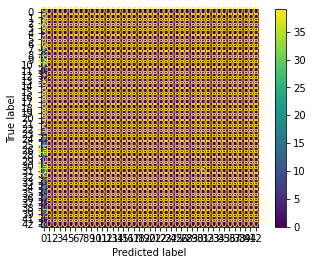

In [87]:


print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train_vec.argmax(axis=1), grid_random_forest.predict(X_train_vec).argmax(axis=1))

Matrice de confusion sur les predictions de données d'entrainement


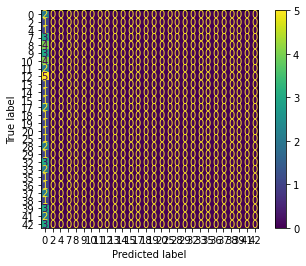

In [88]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test_vec.argmax(axis=1), grid_random_forest.predict(X_test_vec).argmax(axis=1))

## SGDClassifier

Matrice de confusion sur les predictions de données d'entrainement


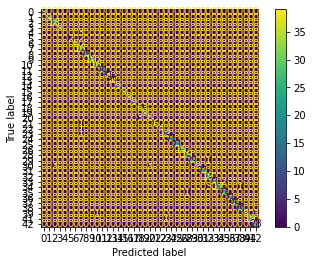

In [91]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_train_vec.argmax(axis=1), model_sgd.predict(X_train_vec))
#print(model_sgd.score(X_test_vec, y_test_vec.argmax(axis=1)))

Matrice de confusion sur les predictions de données d'entrainement


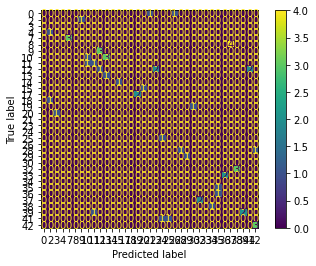

In [92]:
print("Matrice de confusion sur les predictions de données d'entrainement")
ConfusionMatrixDisplay.from_predictions(y_test_vec.argmax(axis=1), model_sgd.predict(X_test_vec))

# Predict
- prend en entrée une phrase et le modèle entrainé
- met en sortie la réponse prédite (utilisation des dictionnaires crée au début)
- Prend en compte la proba de prédiction et propose une reformulation ou les tag les plus proches si proba < à un certain seuil

In [43]:
def predict(phrase : str, trained_model, encodeurX, dic_num_tag, dico_tag_responses):
    #print(phrase)
    
    phrase = extraction_data_X_y(None, True, phrase) #enlever les -, les ' etc
    #print(f"après extraction_data_X_y {phrase}")
    
    phrase_clean = nettoyage([phrase])
    #print(f"après nettoyage {phrase_clean}")
    
    phrase_clean = collage(phrase_clean)
    #print(f"après collage {phrase_clean}")
    
    phrase_vec = vectorizer(phrase_clean, False, encodeurX)
    #print(f"après vectorizer {phrase_vec}")
    
    

    
    prediction = trained_model.predict(phrase_vec)#.argmax(axis=1)
    
    """
    print(trained_model.predict_proba(phrase_vec))
    test_proba = trained_model.predict_proba(phrase_vec) # donne la proba pour chaque tag, leur somme correspond bien à 1
    """
    
    tag_predi = dic_num_tag[prediction[0]]
    #print(tag_predi,prediction)
    reponse = dico_tag_responses[tag_predi]
    #print(reponse)
    
    return reponse #, test_proba#, phrase_vec

phrase_test = "Quels sont les tarifs du cycle ingénieur?"
reponse = predict(phrase_test, model_sgd, encodeur_X_ISEN, num_tag_ISEN, dico_tag_responses_ISEN)
reponse

['Les trois années du ingénieur ont des frais de scolarité s’élevant à 8200 €/an. Au cours de l’année 2020-21, 86% des élèves de dernière année ont été exonérés des frais de scolarité puisque qu’ayant choisi d’étudier en alternance. De plus, ils sont rémunérés par l’entreprise d’accueil. De plus, les élèves de l’ISEN sont éligibles aux bourses de l’enseignement supérieur relevant du ministère de l’éducation nationale et de l’enseignement supérieur et de la recherche.']

## sauvegarde de l'encodeur, et des dictionnaires

In [107]:

with open('C://Users//chdep//Projet_M1_chatbot_guillaume//dic_num_tag.pkl', 'wb') as f:
    pickle.dump(num_tag, f)

    
with open('C://Users//chdep//Projet_M1_chatbot_guillaume//dico_tag_responses.pkl', 'wb') as f:
    pickle.dump(dico_tag_responses, f)
    
with open('C://Users//chdep//Projet_M1_chatbot_guillaume//encodeurX.pkl', 'wb') as f:
    pickle.dump(encodeur_X, f)
    

In [ ]:

with open('name.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)